In [1]:
import os
os.getcwd()

'C:\\Users\\Michael\\0.UniversityOfWaterloo_Homepage\\MSCI609\\0.FinalProject'

In [2]:
from statsmodels.tools.tools import pinv_extended
import statsmodels.api as sm
import sklearn, statsmodels

def regression_analysis(X, y, model):
    
    is_statsmodels = False
    is_sklearn = False
    
    # check for accepted linear models
    if type(model) in [sklearn.linear_model._base.LinearRegression,
                       sklearn.linear_model._ridge.Ridge,
                       sklearn.linear_model._ridge.RidgeCV,
                       sklearn.linear_model._coordinate_descent.Lasso,
                       sklearn.linear_model._coordinate_descent.LassoCV,
                       sklearn.linear_model._coordinate_descent.ElasticNet,
                       sklearn.linear_model._coordinate_descent.ElasticNetCV,
                      ]:
        is_sklearn = True
    elif type(model) in [statsmodels.regression.linear_model.OLS, 
                         statsmodels.base.elastic_net.RegularizedResults,
                        ]:
        is_statsmodels = True
    else:
        print("Only linear models are supported!")
        return None
    
    
    
    has_intercept = False
    
    if is_statsmodels and all(np.array(X)[:,0]==1):
        # statsmodels add_constant has been used already
        has_intercept = True  
    elif is_sklearn and model.intercept_:
        has_intercept = True
        

    
    if is_statsmodels:
        # add_constant has been used already
        x = X
        model_params = model.params
    else: # sklearn model
        if has_intercept:
            x = sm.add_constant(X)
            model_params = np.hstack([np.array([model.intercept_]), model.coef_])
        else:
            x = X
            model_params = model.coef_
        
    #y = np.array(y).ravel()
    
    # define the OLS model
    olsModel = sm.OLS(y, x)
    
    pinv_wexog,_ = pinv_extended(x)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    
    
    return sm.regression.linear_model.OLSResults(olsModel, model_params, normalized_cov_params)

In [3]:
def missing_values_table(df):
    mis_val = df.isnull().sum() # 总缺失值
    mis_val_percent = 100 * df.isnull().sum() / len(df) # 缺失值比例
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1) # 缺失值制成表格
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0:'Missing Values',
                                                               1:'% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values',ascending=False).round(1)
    # 缺失值比例列由大到小排序
    
    print('Your selected dataframe has {} columns.\nThere are {} columns that have missing values.'.format(df.shape[1], mis_val_table_ren_columns.shape[0]))
    # 打印缺失值信息
    
    return mis_val_table_ren_columns

In [4]:
import lightgbm as lgb

import numpy as np
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier # GBDT-Gradient Bosting decision tree
from sklearn.preprocessing import LabelEncoder # For transition
from sklearn.metrics import roc_curve,auc
from scipy import interp
import matplotlib.pyplot as plt
import seaborn as sns

filePath_01="Obligation_data.csv" #Clean data
filePath_02="indl_new.xlsx" #New data with industry information
df1 = pd.read_csv(filePath_01)
df2 = pd.read_excel(filePath_02)

In [5]:
df1

,Unnamed: 0,Pension - Accumulated Benefit Obligation,Pension - Long-Term Asset,Pension Actual Return on Plan Assets,Pension Beginning Plan Assets,Pension Employer Contribution,Employer Contributions - Expected Next Year,Pension - Current Liability,Pension Benefits Paid,Pension - Projected Benefit Obligation,...,Postretirement - Long-Term Liability,Postretirement Other Adjustments (Plan Assets),Postretirement Other Adjustments (Net Benefit Asset/Liability),Postretirement Net Total Other Costs,Postretirement Benefits Paid,Postretirement Participant Contributions,Postretirement Prior Service,Postretirement Service Cost,Global Company Key,Record_Date
0,0,151.900000,0.000,8.600,129.900,0.400,3.100000,0.400000,7.100,159.100,...,0.400000,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2020-05-31
1,1,153.000000,10.400,23.800,131.800,2.700,2.300000,0.400000,6.800,159.000,...,178.892536,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2021-05-31
2,2,116.500000,9.700,-16.700,158.400,0.500,0.300000,0.300000,7.600,120.200,...,178.892536,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2022-05-31
3,3,105.300000,8.700,-7.400,126.200,0.300,0.400000,0.200000,5.800,108.000,...,178.892536,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2023-05-31
4,4,2007.997043,0.000,0.643,5.819,0.300,40.814273,0.000000,0.525,8.662,...,0.072000,0.000000,0.038000,0.003000,0.017000,0.000000,0.00000,0.000000,1019,2019-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6383,7170,2007.997043,9.099,369.631,6419.067,255.898,456.068000,0.000000,194.483,9042.877,...,706.279000,0.000000,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2021-12-31
6384,7171,2007.997043,49.162,-1062.329,6528.946,339.860,241.536000,0.000000,203.061,6308.785,...,594.221000,0.000000,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2022-12-31
6385,7172,2007.997043,14.895,-2.709,897.768,40.624,37.915000,7.044455,24.374,1113.070,...,135.410000,0.642125,-0.089208,0.000000,18.182696,0.000000,-18.60939,10.833000,353444,2021-12-31
6386,7173,2007.997043,30.123,-150.612,819.332,33.737,28.918000,7.044455,49.401,778.365,...,101.212000,0.642125,-0.089208,0.000000,18.182696,0.000000,-18.60939,8.434000,353444,2022-12-31


In [6]:
df2

,Global Company Key,Industry Format,Data Format,Level of Consolidation,Population Source,Pension - Accumulated Benefit Obligation,Pension - Accumulated Benefit Obligation (Underfunded),Pension - Other asset/liability,Pension - Long-Term Asset,Pension Actual Return on Plan Assets,...,Postretirement Net Total Other Costs,Postretirement Benefits Paid,Postretirement Participant Contributions,Postretirement Prior Service,Postretirement Service Cost,Postretirement Unrecognized Transition Obligations,Data Date,Pension Benefit - Information Date,GIC Groups,Ticker Symbol
0,1004,INDL,STD,C,D,151.900,NaN,NaN,0.000,8.600,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-31,2020-05-31,2010.0,AIR
1,1004,INDL,STD,C,D,153.000,NaN,NaN,10.400,23.800,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-31,2021-05-31,2010.0,AIR
2,1004,INDL,STD,C,D,116.500,NaN,NaN,9.700,-16.700,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-31,2022-05-31,2010.0,AIR
3,1004,INDL,STD,C,D,105.300,NaN,NaN,8.700,-7.400,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-31,2023-05-31,2010.0,AIR
4,1019,INDL,STD,C,D,NaN,NaN,NaN,0.000,0.643,...,0.003,0.017,0.0,0.0,0.000,NaN,2019-12-31,2019-12-31,2020.0,AFAP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8283,351590,INDL,STD,C,D,NaN,NaN,NaN,9.099,369.631,...,NaN,0.000,0.0,NaN,NaN,NaN,2021-12-31,2021-12-31,2010.0,DTRUY
8284,351590,INDL,STD,C,D,NaN,NaN,NaN,49.162,-1062.329,...,NaN,0.000,0.0,NaN,NaN,NaN,2022-12-31,2022-12-31,2010.0,DTRUY
8285,353444,INDL,STD,C,D,NaN,NaN,NaN,14.895,-2.709,...,0.000,NaN,0.0,NaN,10.833,NaN,2021-12-31,2021-12-31,3030.0,HLN
8286,353444,INDL,STD,C,D,NaN,NaN,NaN,30.123,-150.612,...,0.000,NaN,0.0,NaN,8.434,NaN,2022-12-31,2022-12-31,3030.0,HLN


In [7]:
df1 = df1.drop("Unnamed: 0",axis=1)#drop unrelated column

In [8]:
# df2.info()
# GIC Groups
#Global Company Key
df2 = df2.sort_values(by = 'Data Date',ascending=False)#keep the newest data & Delete the rest of the data
df2.drop_duplicates(subset=["Global Company Key"], keep='first', inplace=True)
# df2[df2.duplicated()]
df_find_industry = df2[["Global Company Key","GIC Groups"]]

In [9]:
df_find_industry["Global Company Key"] = df_find_industry["Global Company Key"].astype("int").astype("str")
df1["Global Company Key"] = df1["Global Company Key"].astype("str")

In [10]:
missing_values_table(df_find_industry)

Your selected dataframe has 2 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
GIC Groups,5,0.2


In [11]:
df_find_industry = df_find_industry.dropna()

In [12]:
missing_values_table(df_find_industry)

Your selected dataframe has 2 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [13]:
df_find_industry

,Global Company Key,GIC Groups
783,4498,2010.0
4519,28555,5020.0
1439,7343,4530.0
6688,143357,4510.0
2978,14954,2010.0
...,...,...
4240,26272,5510.0
4241,26305,2530.0
6990,158765,6010.0
6456,124254,1510.0


In [14]:
df_analysis_decritive = pd.merge(df1,df_find_industry,on='Global Company Key')

In [15]:
# data_x_fixed_effect = df_analysis_decritive.copy()
import datetime  # 将日期列分解成年、月、日
df_analysis_decritive['Record_Date']=pd.to_datetime(df_analysis_decritive['Record_Date'])
df_analysis_decritive['year'] = df_analysis_decritive["Record_Date"].dt.year
# df_analysis_decritive = df_analysis_decritive.set_index(["Global Company Key","year"])
# df_analysis_decritive = df_analysis_decritive.drop("Record_Date",axis=1)
df_analysis_decritive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6385 entries, 0 to 6384
Data columns (total 36 columns):
 #   Column                                                               Non-Null Count  Dtype         
---  ------                                                               --------------  -----         
 0   Pension - Accumulated Benefit Obligation                             6385 non-null   float64       
 1   Pension - Long-Term Asset                                            6385 non-null   float64       
 2   Pension Actual Return on Plan Assets                                 6385 non-null   float64       
 3   Pension Beginning Plan Assets                                        6385 non-null   float64       
 4   Pension Employer Contribution                                        6385 non-null   float64       
 5   Employer Contributions - Expected Next Year                          6385 non-null   float64       
 6   Pension - Current Liability                     

In [16]:
df_analysis_decritive["GIC Groups"].value_counts()

GIC Groups
2010.0    825
4010.0    747
1510.0    651
5510.0    643
1010.0    351
3020.0    278
3520.0    260
2020.0    244
4030.0    235
4520.0    230
3510.0    204
5020.0    197
4020.0    181
2030.0    176
5010.0    160
4530.0    148
2510.0    146
2520.0    137
4510.0    117
2530.0    112
2550.0     97
3010.0     90
3030.0     65
6020.0     51
6010.0     39
2540.0      1
Name: count, dtype: int64

进行Anova方差分析

In [17]:
df_analysis_decritive["GIC Groups"]= df_analysis_decritive["GIC Groups"].astype('str')

GICS Industry Groups
Mnemonic

Periodicity

Format

Units

GGROUP

Scalar

Code

4 digits

This item represents the second level in the hierarchy of the Global Industry Classification Standard (GICS). The Industry Group is represented by the leftmost 4 digits of the total GICS code.

Following is a sample of the GICS classification codes for United Airlines, Inc. (GVKEY 010484):

Sector:

20 - Industrials

Industry Group:

2030 - Transportation

Industry:

203020 - Airlines

Sub-Industry:


2010.0    Capital Goods 资本货物; 
4010.0    Banks银行;
1510.0    Material 材料
5510.0    Utilities 公用事业643
1010.0    Energy 351
3020.0    Food, Beverage & Tobacco278
3520.0    Pharmaceuticals, Biotechnology & Life Science 医药生物制药和科学260
2020.0    商业和专业服务244
4030.0    Insurance 保险235
4520.0    Technology Hardware & Equipment230
3510.0    Health Care Equipment & Services204
5020.0    Unknow197 - Media & Entertainment
4020.0    Diversified Financials 金融集团181
2030.0    Transportation运输176
5010.0    Telecommunication Services160
4530.0    Semiconductors & Semiconductor Equiment148
2510.0    Automobile and Components 汽车和部件146
2520.0    Consumer Durables and Apparel耐用消费品和服装137
4510.0    Software & Services 软件服务117
2530.0    Consumer Services 消费服务112
2550.0    Retailing 零售97
3010.0    Food& staples Retailing90
3030.0    Household & Personal Products家庭和个人用品65
6020.0    unknow51
6010.0    unknow39
2540.0    Media媒体1

%
https://zhuanlan.zhihu.com/p/426510386

In [18]:
# 
dict = {"2010.0" : "Capital Goods",
"4010.0"  : "Banks",
"1510.0"  : "Material",
"5510.0"  : "Utilities",
"1010.0"  :  "Energy",
"3020.0"   : "Food, Beverage &Tobacco",
"3520.0"   : "Pharmaceuticals, Biotechnology & Life Science" ,
"2020.0"   : "Busniess and Professional",
"4030.0"   : "Insurance",
"4520.0"   : "Technology Hardware & Equipment",
"3510.0"   : "Health Care Equipment & Services",
"5020.0"   : "Media & Entertainment",
"4020.0"   : "Diversified Financials",
"2030.0"   : "Transportation",
"5010.0"   : "Telecommunication Services",
"4530.0"   : "Semiconductors & Semiconductor Equiment",
"2510.0"   : "Automobile and Components",
"2520.0"   : "Consumer Durables and Apparel",
"4510.0"   : "Software & Service",
"2530.0"   : "Consumer Services",
"2550.0"   : "Retailing",
"3010.0"   : "Food& staples Retailing",
"3030.0"   : "Household & Personal Products",
"6020.0"   : "Single-Family Residential REITs",
"6010.0"   : "Equity Real Estate Investment Trusts",
"2540.0"   : "Media"}


#5020 unkonw3 - > Media & Entertainment
#6010 unknow1 Equity Real Estate Investment Trusts
#6020 unkonw2 Single-Family Residential REITs
# will remap the values
# Print the dictionary
print(dict)
 
# Remap the values of the dataframe
df_analysis_decritive["GIC Groups"] = df_analysis_decritive["GIC Groups"].map(dict)

{'2010.0': 'Capital Goods', '4010.0': 'Banks', '1510.0': 'Material', '5510.0': 'Utilities', '1010.0': 'Energy', '3020.0': 'Food, Beverage &Tobacco', '3520.0': 'Pharmaceuticals, Biotechnology & Life Science', '2020.0': 'Busniess and Professional', '4030.0': 'Insurance', '4520.0': 'Technology Hardware & Equipment', '3510.0': 'Health Care Equipment & Services', '5020.0': 'Media & Entertainment', '4020.0': 'Diversified Financials', '2030.0': 'Transportation', '5010.0': 'Telecommunication Services', '4530.0': 'Semiconductors & Semiconductor Equiment', '2510.0': 'Automobile and Components', '2520.0': 'Consumer Durables and Apparel', '4510.0': 'Software & Service', '2530.0': 'Consumer Services', '2550.0': 'Retailing', '3010.0': 'Food& staples Retailing', '3030.0': 'Household & Personal Products', '6020.0': 'Single-Family Residential REITs', '6010.0': 'Equity Real Estate Investment Trusts', '2540.0': 'Media'}


In [20]:
df_analysis_decritive["GIC Groups"]

0                       Capital Goods
1                       Capital Goods
2                       Capital Goods
3                       Capital Goods
4           Busniess and Professional
                    ...              
6380                    Capital Goods
6381                    Capital Goods
6382    Household & Personal Products
6383    Household & Personal Products
6384                    Capital Goods
Name: GIC Groups, Length: 6385, dtype: object

# Descriptive Analysis 1 - Boxplot of Benefit Obligation

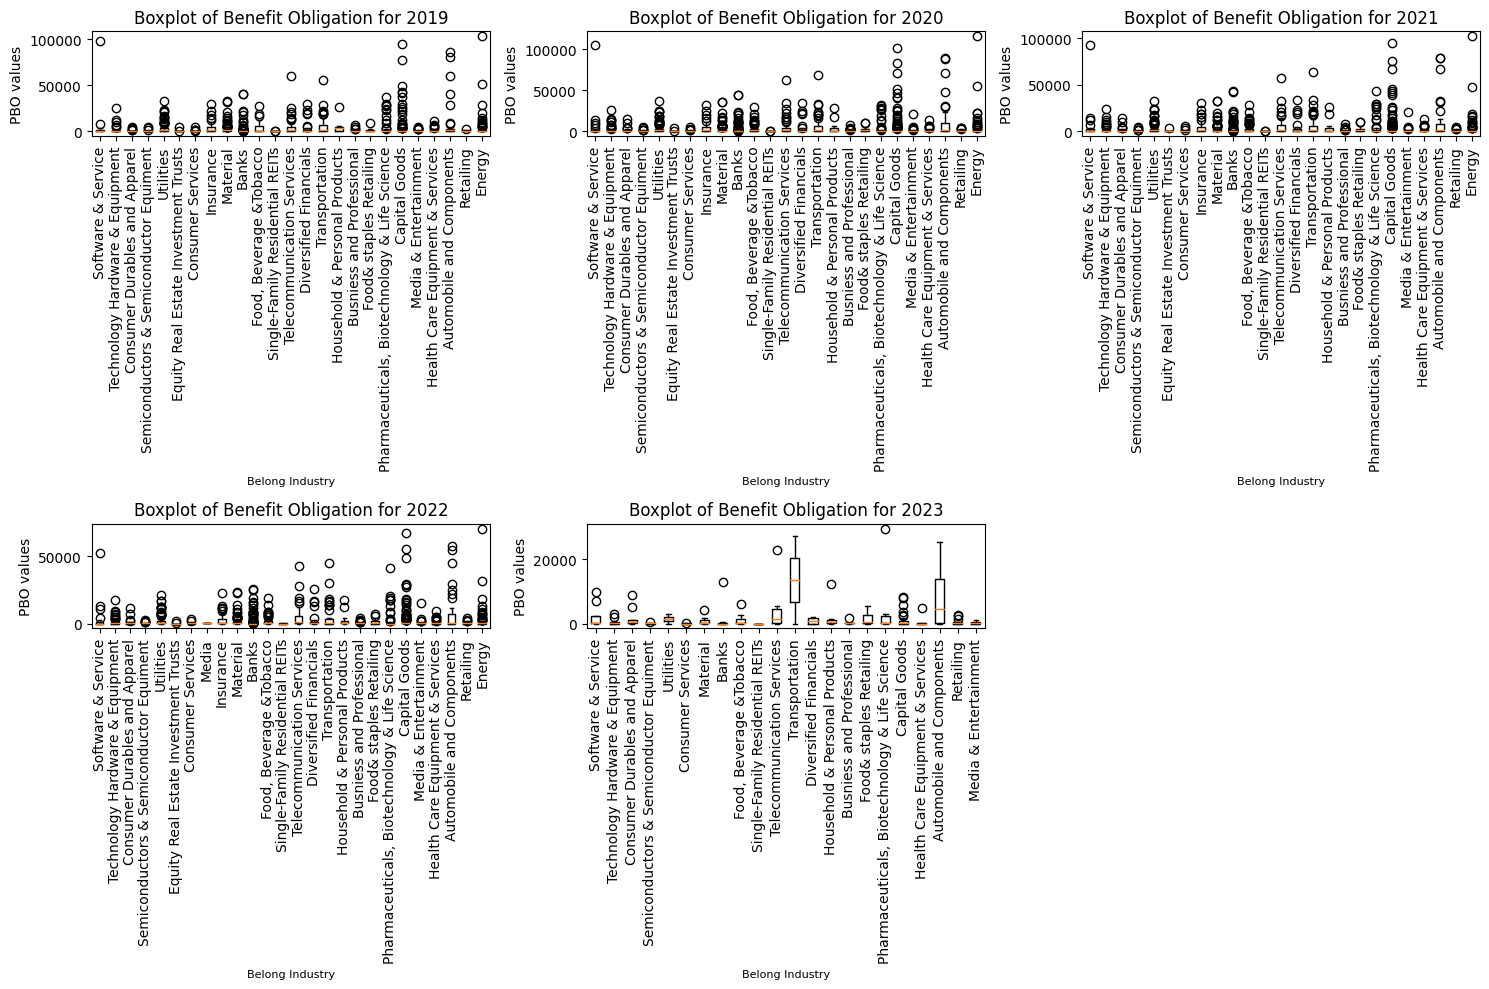

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming "year" is a column in df_analysis_decritive
# If not, replace it with the correct column name
years = df_analysis_decritive["year"].unique().tolist()
years = sorted(list(map(int, years)))

# Set up the 2x3 subplots grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the 2D array of subplots for easy indexing
axes = axes.flatten()

# Iterate over each year and create a subplot
for i, year in enumerate(years):
    # Filter data for the current year
    df_year = df_analysis_decritive[df_analysis_decritive["year"] == year]

    # Boxplot of "Pension - Projected Benefit Obligation" at different "GIC Groups"
    labels = list(set(df_year["GIC Groups"]))
    Mnt = [df_year[df_year["GIC Groups"] == label]["Pension - Projected Benefit Obligation"] for label in labels]

    # Create boxplot in the current subplot
    axes[i].boxplot(Mnt, labels=labels)
    axes[i].set_xlabel('Belong Industry', fontsize=8)  # Adjust font size
    axes[i].set_ylabel('PBO values')
    axes[i].set_title(f'Boxplot of Benefit Obligation for {year}')
    axes[i].tick_params(axis='x', rotation=90)

# Remove the last empty subplot if there are fewer than 6 years
if len(years) < 6:
    fig.delaxes(axes[-1])

# Adjust layout and save the figure
plt.tight_layout()
# plt.savefig('./BoxplotOfBOinDifferentIndustryByYear_2x3.jpg')
plt.show()

In [65]:
df_analysis_decritive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6385 entries, 0 to 6384
Data columns (total 36 columns):
 #   Column                                                               Non-Null Count  Dtype         
---  ------                                                               --------------  -----         
 0   Pension - Accumulated Benefit Obligation                             6385 non-null   float64       
 1   Pension - Long-Term Asset                                            6385 non-null   float64       
 2   Pension Actual Return on Plan Assets                                 6385 non-null   float64       
 3   Pension Beginning Plan Assets                                        6385 non-null   float64       
 4   Pension Employer Contribution                                        6385 non-null   float64       
 5   Employer Contributions - Expected Next Year                          6385 non-null   float64       
 6   Pension - Current Liability                     

In [73]:
len(df_analysis_decritive["Global Company Key"].unique())

1783

In [74]:
len(df_analysis_decritive["GIC Groups"].unique())

26

In [75]:
dict

{'2010.0': 'Capital Goods',
 '4010.0': 'Banks',
 '1510.0': 'Material',
 '5510.0': 'Utilities',
 '1010.0': 'Energy',
 '3020.0': 'Food, Beverage &Tobacco',
 '3520.0': 'Pharmaceuticals, Biotechnology & Life Science',
 '2020.0': 'Busniess and Professional',
 '4030.0': 'Insurance',
 '4520.0': 'Technology Hardware & Equipment',
 '3510.0': 'Health Care Equipment & Services',
 '5020.0': 'Media & Entertainment',
 '4020.0': 'Diversified Financials',
 '2030.0': 'Transportation',
 '5010.0': 'Telecommunication Services',
 '4530.0': 'Semiconductors & Semiconductor Equiment',
 '2510.0': 'Automobile and Components',
 '2520.0': 'Consumer Durables and Apparel',
 '4510.0': 'Software & Service',
 '2530.0': 'Consumer Services',
 '2550.0': 'Retailing',
 '3010.0': 'Food& staples Retailing',
 '3030.0': 'Household & Personal Products',
 '6020.0': 'Single-Family Residential REITs',
 '6010.0': 'Equity Real Estate Investment Trusts',
 '2540.0': 'Media'}

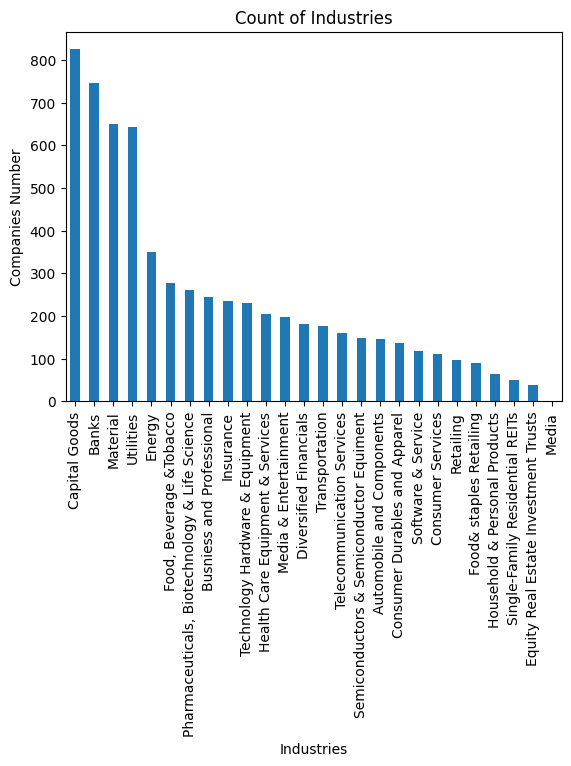

In [28]:
counts = df_analysis_decritive["GIC Groups"].value_counts()
counts.plot(kind='bar')
plt.xlabel('Industries')
plt.ylabel('Companies Number')
plt.title('Count of Industries')
plt.show()

# 从上图可以看到，数据清洗后的6,385个数据样本中，共计有1,783家企业，其来行业领域涉及 Capital Goods, Banks, Material, Utilities,Telecommunication Services 到 Software & Service 等共26个行业。



In [126]:
df_analysis_decritive

,Pension - Accumulated Benefit Obligation,Pension - Long-Term Asset,Pension Actual Return on Plan Assets,Pension Beginning Plan Assets,Pension Employer Contribution,Employer Contributions - Expected Next Year,Pension - Current Liability,Pension Benefits Paid,Pension - Projected Benefit Obligation,Pension Plans - Interest Cost,...,Postretirement Other Adjustments (Net Benefit Asset/Liability),Postretirement Net Total Other Costs,Postretirement Benefits Paid,Postretirement Participant Contributions,Postretirement Prior Service,Postretirement Service Cost,Global Company Key,Record_Date,GIC Groups,year
0,151.900000,0.000,8.600,129.900,0.400,3.100000,0.400000,7.100,159.100,3.800,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2020-05-31,Capital Goods,2020
1,153.000000,10.400,23.800,131.800,2.700,2.300000,0.400000,6.800,159.000,3.100,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2021-05-31,Capital Goods,2021
2,116.500000,9.700,-16.700,158.400,0.500,0.300000,0.300000,7.600,120.200,3.100,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2022-05-31,Capital Goods,2022
3,105.300000,8.700,-7.400,126.200,0.300,0.400000,0.200000,5.800,108.000,3.300,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2023-05-31,Capital Goods,2023
4,2007.997043,0.000,0.643,5.819,0.300,40.814273,0.000000,0.525,8.662,0.319,...,0.038000,0.003000,0.017000,0.000000,0.00000,0.000000,1019,2019-12-31,Busniess and Professional,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6380,2007.997043,9.099,369.631,6419.067,255.898,456.068000,0.000000,194.483,9042.877,109.183,...,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2021-12-31,Capital Goods,2021
6381,2007.997043,49.162,-1062.329,6528.946,339.860,241.536000,0.000000,203.061,6308.785,140.005,...,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2022-12-31,Capital Goods,2022
6382,2007.997043,14.895,-2.709,897.768,40.624,37.915000,7.044455,24.374,1113.070,1.354,...,-0.089208,0.000000,18.182696,0.000000,-18.60939,10.833000,353444,2021-12-31,Household & Personal Products,2021
6383,2007.997043,30.123,-150.612,819.332,33.737,28.918000,7.044455,49.401,778.365,1.205,...,-0.089208,0.000000,18.182696,0.000000,-18.60939,8.434000,353444,2022-12-31,Household & Personal Products,2022


In [128]:
df_analysis_decritive[df_analysis_decritive["Pension - Projected Benefit Obligation"]==0][["GIC Groups","Pension - Projected Benefit Obligation"]]

,GIC Groups,Pension - Projected Benefit Obligation
27,Busniess and Professional,0.0
60,"Food, Beverage &Tobacco",0.0
61,"Food, Beverage &Tobacco",0.0
575,Consumer Durables and Apparel,0.0
576,Consumer Durables and Apparel,0.0
...,...,...
5981,Material,0.0
5982,Material,0.0
5983,Material,0.0
6000,Media & Entertainment,0.0


In [76]:
means = df_analysis_decritive["Pension - Projected Benefit Obligation"].groupby([df_analysis_decritive["GIC Groups"]
                                                                                 , df_analysis_decritive['year']]).mean()
means

GIC Groups                 year
Automobile and Components  2019    11442.671448
                           2020    11888.488784
                           2021     9988.316105
                           2022     8268.847944
                           2023     8428.561333
                                       ...     
Utilities                  2019     2677.205192
                           2020     2827.575274
                           2021     2623.624358
                           2022     2043.739308
                           2023     1442.937500
Name: Pension - Projected Benefit Obligation, Length: 123, dtype: float64

In [77]:
means.unstack()

year,2019,2020,2021,2022,2023
GIC Groups,,,,,
Automobile and Components,11442.671448,11888.488784,9988.316105,8268.847944,8428.561333
Banks,1188.147228,1646.054571,1669.466115,1267.073869,1947.446429
Busniess and Professional,669.358020,616.183328,601.975581,425.765105,227.095000
Capital Goods,3908.025916,3778.704469,3583.277420,2547.194355,1083.915600
Consumer Durables and Apparel,640.542174,1416.968258,1209.731444,929.246184,1854.308444
Consumer Services,376.685304,515.281806,558.419214,404.287038,43.793500
Diversified Financials,2978.348463,2935.594292,2967.790533,2299.862326,912.586500
Energy,3543.422744,3850.339125,3489.172000,2507.622138,NaN
Equity Real Estate Investment Trusts,534.628700,504.346800,518.270667,279.782700,NaN


In [130]:
means = df_analysis_decritive["Pension - Projected Benefit Obligation"].groupby(df_analysis_decritive["GIC Groups"]).mean()
means.sort_values()
means.mean()

2501.1745128809243

In [131]:
df_analysis_decritive

,Pension - Accumulated Benefit Obligation,Pension - Long-Term Asset,Pension Actual Return on Plan Assets,Pension Beginning Plan Assets,Pension Employer Contribution,Employer Contributions - Expected Next Year,Pension - Current Liability,Pension Benefits Paid,Pension - Projected Benefit Obligation,Pension Plans - Interest Cost,...,Postretirement Other Adjustments (Net Benefit Asset/Liability),Postretirement Net Total Other Costs,Postretirement Benefits Paid,Postretirement Participant Contributions,Postretirement Prior Service,Postretirement Service Cost,Global Company Key,Record_Date,GIC Groups,year
0,151.900000,0.000,8.600,129.900,0.400,3.100000,0.400000,7.100,159.100,3.800,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2020-05-31,Capital Goods,2020
1,153.000000,10.400,23.800,131.800,2.700,2.300000,0.400000,6.800,159.000,3.100,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2021-05-31,Capital Goods,2021
2,116.500000,9.700,-16.700,158.400,0.500,0.300000,0.300000,7.600,120.200,3.100,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2022-05-31,Capital Goods,2022
3,105.300000,8.700,-7.400,126.200,0.300,0.400000,0.200000,5.800,108.000,3.300,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2023-05-31,Capital Goods,2023
4,2007.997043,0.000,0.643,5.819,0.300,40.814273,0.000000,0.525,8.662,0.319,...,0.038000,0.003000,0.017000,0.000000,0.00000,0.000000,1019,2019-12-31,Busniess and Professional,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6380,2007.997043,9.099,369.631,6419.067,255.898,456.068000,0.000000,194.483,9042.877,109.183,...,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2021-12-31,Capital Goods,2021
6381,2007.997043,49.162,-1062.329,6528.946,339.860,241.536000,0.000000,203.061,6308.785,140.005,...,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2022-12-31,Capital Goods,2022
6382,2007.997043,14.895,-2.709,897.768,40.624,37.915000,7.044455,24.374,1113.070,1.354,...,-0.089208,0.000000,18.182696,0.000000,-18.60939,10.833000,353444,2021-12-31,Household & Personal Products,2021
6383,2007.997043,30.123,-150.612,819.332,33.737,28.918000,7.044455,49.401,778.365,1.205,...,-0.089208,0.000000,18.182696,0.000000,-18.60939,8.434000,353444,2022-12-31,Household & Personal Products,2022


In [119]:
means.to_csv('Obligation_ranking.csv')

In [96]:
means = df_analysis_decritive["Pension - Projected Benefit Obligation"].groupby([df_analysis_decritive["GIC Groups"]
                                                                                 , df_analysis_decritive['year']]).mean().sort_values()
means.unstack()
# .where(means["year"]==2022)

year,2019,2020,2021,2022,2023
GIC Groups,,,,,
Automobile and Components,11442.671448,11888.488784,9988.316105,8268.847944,8428.561333
Banks,1188.147228,1646.054571,1669.466115,1267.073869,1947.446429
Busniess and Professional,669.358020,616.183328,601.975581,425.765105,227.095000
Capital Goods,3908.025916,3778.704469,3583.277420,2547.194355,1083.915600
Consumer Durables and Apparel,640.542174,1416.968258,1209.731444,929.246184,1854.308444
Consumer Services,376.685304,515.281806,558.419214,404.287038,43.793500
Diversified Financials,2978.348463,2935.594292,2967.790533,2299.862326,912.586500
Energy,3543.422744,3850.339125,3489.172000,2507.622138,NaN
Equity Real Estate Investment Trusts,534.628700,504.346800,518.270667,279.782700,NaN


In [97]:
type(means.unstack())

pandas.core.frame.DataFrame

In [99]:
means.unstack().to_csv('Obligation_aggregation.csv')

In [64]:
df_analysis_decritive["year"].value_counts()

0       2020
1       2021
2       2022
3       2023
4       2019
        ... 
6380    2021
6381    2022
6382    2021
6383    2022
6384    2022
Name: year, Length: 6385, dtype: object

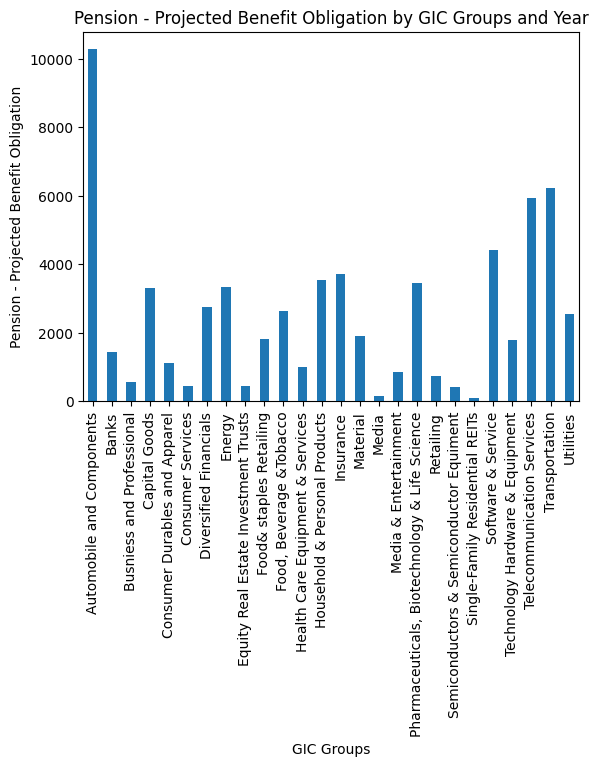

In [61]:
df_analysis_decritive['year'] = df_analysis_decritive['year'].astype(str)
grouped = df_analysis_decritive["Pension - Projected Benefit Obligation"].groupby(df_analysis_decritive["GIC Groups"]).mean()
grouped.plot(kind='bar')
plt.title('Pension - Projected Benefit Obligation by GIC Groups and Year')
plt.xlabel('GIC Groups')
plt.ylabel('Pension - Projected Benefit Obligation')
plt.show()

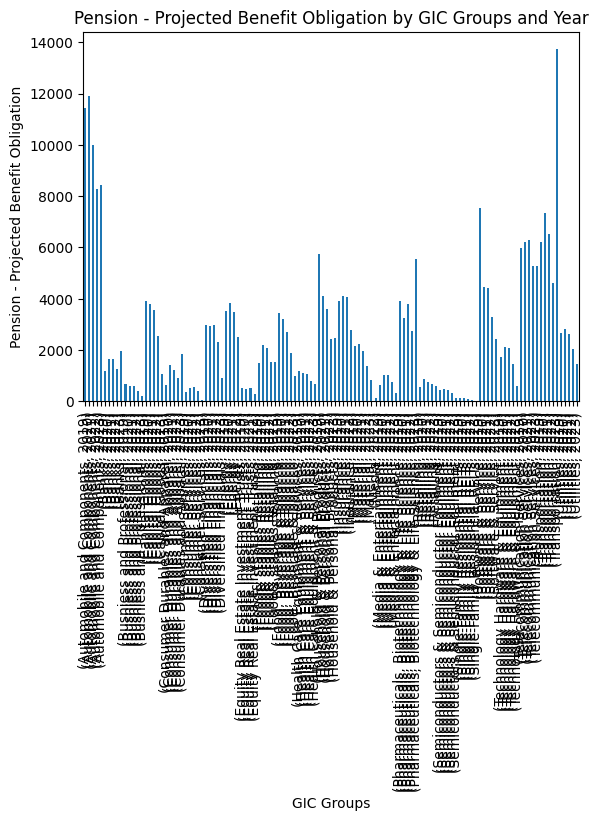

In [62]:
df_analysis_decritive['year'] = df_analysis_decritive['year'].astype(str)
grouped = df_analysis_decritive["Pension - Projected Benefit Obligation"].groupby([df_analysis_decritive["GIC Groups"], df_analysis_decritive["year"]]).mean()
grouped.plot(kind='bar')
plt.title('Pension - Projected Benefit Obligation by GIC Groups and Year')
plt.xlabel('GIC Groups')
plt.ylabel('Pension - Projected Benefit Obligation')
plt.show()

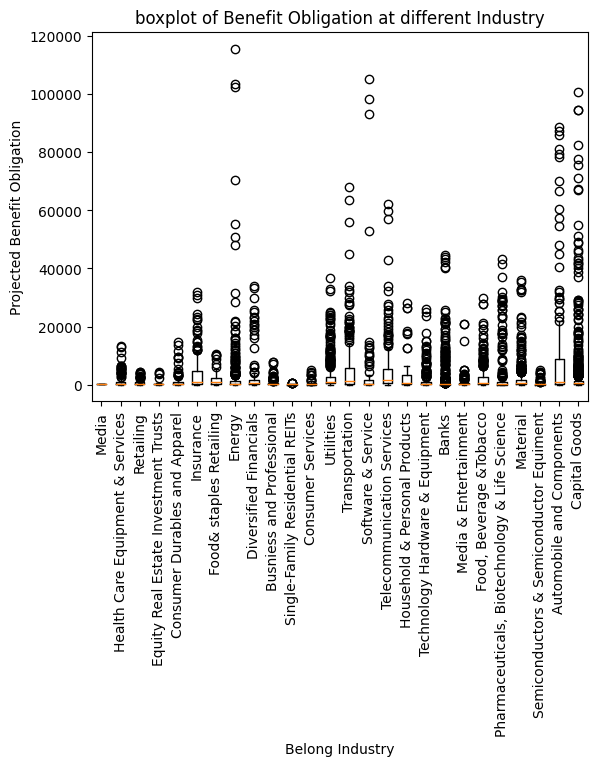

In [65]:
#boxplot of MntWines at different Marital_Status
#df.Marital_Status的类型
labels=list(set(df_analysis_decritive["GIC Groups"]))
labels
Mnt=[]
#进行分组
for label in labels:
    Mnt.append(df_analysis_decritive[df_analysis_decritive["GIC Groups"]==label]["Pension - Projected Benefit Obligation"])
#绘制箱线图
plt.boxplot(Mnt,labels=labels)
plt.xlabel('Belong Industry')
plt.ylabel('Projected Benefit Obligation')
plt.title('boxplot of Benefit Obligation at different Industry')
plt.xticks(rotation=90) 
plt.savefig('./BoxplotOfBOinDifferentIndustry.jpg')
plt.show()

In [22]:
df_analysis_decritive.to_csv('Obligation_data_with_industry_V2.csv')

In [100]:
missing_values_table(df_analysis_decritive)

Your selected dataframe has 36 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [101]:
df_analysis_decritive

,Pension - Accumulated Benefit Obligation,Pension - Long-Term Asset,Pension Actual Return on Plan Assets,Pension Beginning Plan Assets,Pension Employer Contribution,Employer Contributions - Expected Next Year,Pension - Current Liability,Pension Benefits Paid,Pension - Projected Benefit Obligation,Pension Plans - Interest Cost,...,Postretirement Other Adjustments (Net Benefit Asset/Liability),Postretirement Net Total Other Costs,Postretirement Benefits Paid,Postretirement Participant Contributions,Postretirement Prior Service,Postretirement Service Cost,Global Company Key,Record_Date,GIC Groups,year
0,151.900000,0.000,8.600,129.900,0.400,3.100000,0.400000,7.100,159.100,3.800,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2020-05-31,Capital Goods,2020
1,153.000000,10.400,23.800,131.800,2.700,2.300000,0.400000,6.800,159.000,3.100,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2021-05-31,Capital Goods,2021
2,116.500000,9.700,-16.700,158.400,0.500,0.300000,0.300000,7.600,120.200,3.100,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2022-05-31,Capital Goods,2022
3,105.300000,8.700,-7.400,126.200,0.300,0.400000,0.200000,5.800,108.000,3.300,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2023-05-31,Capital Goods,2023
4,2007.997043,0.000,0.643,5.819,0.300,40.814273,0.000000,0.525,8.662,0.319,...,0.038000,0.003000,0.017000,0.000000,0.00000,0.000000,1019,2019-12-31,Busniess and Professional,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6380,2007.997043,9.099,369.631,6419.067,255.898,456.068000,0.000000,194.483,9042.877,109.183,...,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2021-12-31,Capital Goods,2021
6381,2007.997043,49.162,-1062.329,6528.946,339.860,241.536000,0.000000,203.061,6308.785,140.005,...,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2022-12-31,Capital Goods,2022
6382,2007.997043,14.895,-2.709,897.768,40.624,37.915000,7.044455,24.374,1113.070,1.354,...,-0.089208,0.000000,18.182696,0.000000,-18.60939,10.833000,353444,2021-12-31,Household & Personal Products,2021
6383,2007.997043,30.123,-150.612,819.332,33.737,28.918000,7.044455,49.401,778.365,1.205,...,-0.089208,0.000000,18.182696,0.000000,-18.60939,8.434000,353444,2022-12-31,Household & Personal Products,2022


In [72]:
# df_analysis_decritive


# # 绘制QQ图检验数据的正态性
# import pandas as pd
# import statsmodels.api as sm
# import matplotlib.pyplot as plt


# filled_out_list_pic = [
#                    'Pension - Accumulated Benefit Obligation',
#                    'Postretirement Benefit Obligation',
#                   'Global Company Key',
#                   'Record_Date',
#                   'GIC Groups',
#                   'year'] #Postretirement Benefit Obligation

# def plot_test_normality(n):
#     # input_path = "E:\\Data\\"
#     # df = pd.read_csv(input_path + 'data.csv', header=0, encoding='gbk')
#     # df = df.drop(['lng', 'lat'], axis=1)
#     # df = df.dropna(axis=0, how='any')
#     for col in list(df_analysis_decritive.columns):
#         while n <= 2:
#             if col in filled_out_list_pic:
#                 pass
#             else:
#                 n+=1
#                 figure, axs = plt.subplots(figsize=(8, 6), dpi=600)
#                 probplot = sm.ProbPlot(df_analysis_decritive[col].values, fit=True)
#                 probplot.ppplot(line='45', ax=axs)
#                 axs.set_title(str(col))
#                 plt.tight_layout()
#         # figure.savefig("E:\\Figures\\normality\\" + str(col) + ".png", dpi=600)

# if __name__ == '__main__':
#     plot_test_normality(n=0)

# Descriptive Analysis 2 - QQ plot for some groups 

# Descriptive Analysis 3 - shapiro normalnality for some groups for Y variables

The scatter points of the two groups on the Q-Q plot basically deviate from the diagonal distribution, suggesting that the data of the two groups are not normally distributed; the results of the "Shapiro-Wilk normality test (S-W normality test)" show that the P-values of the two groups are 0.0, 0.0, respectively, and both of them are <0.1, which also suggests that the data of the two groups do not obey the normal distribution and do not fulfill the condition.

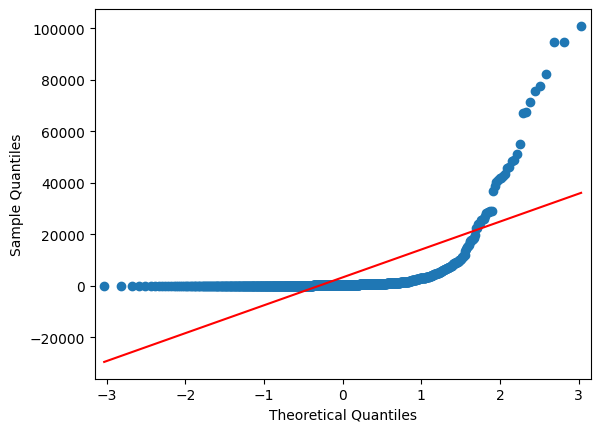

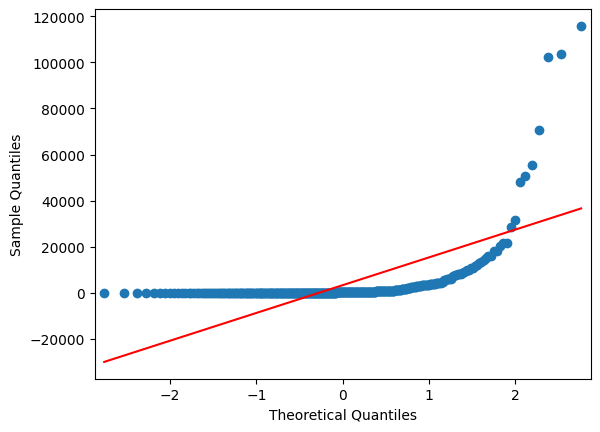

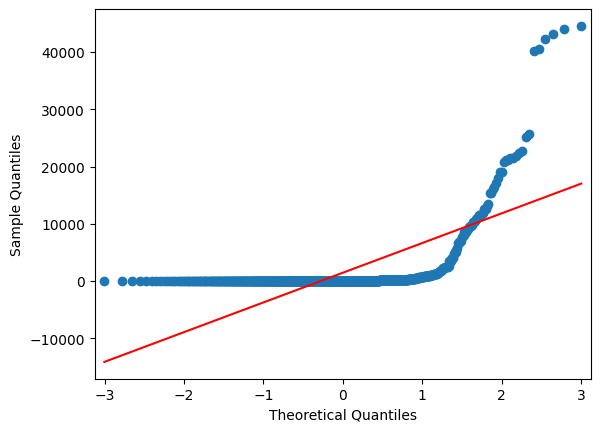

In [73]:
import statsmodels.api as sm #导入statsmodels.api包
import pylab
sm.qqplot(df_analysis_decritive.loc[df_analysis_decritive.loc[:,'GIC Groups']=='Capital Goods','Pension - Projected Benefit Obligation'], line='s') #选取第一组数据
pylab.show() #显示第一组QQ图
sm.qqplot(df_analysis_decritive.loc[df_analysis_decritive.loc[:,'GIC Groups']=='Energy','Pension - Projected Benefit Obligation'], line='s') #选取第二组数据
pylab.show() #显示第二组QQ图
sm.qqplot(df_analysis_decritive.loc[df_analysis_decritive.loc[:,'GIC Groups']=='Banks','Pension - Projected Benefit Obligation'], line='s') #选取第二组数据
pylab.show() #显示第二组QQ图

In [102]:
from scipy import stats #导入scipy包
# shapiro_test1 = stats.shapiro(df_analysis_decritive.loc[df_analysis_decritive.loc[:,'group']=='A','血红蛋白']) 
# print(shapiro_test1)
shapiro_test2 = stats.shapiro(df_analysis_decritive.loc[df_analysis_decritive.loc[:,'GIC Groups']=='Capital Goods','Pension - Projected Benefit Obligation'])
print(shapiro_test2)
shapiro_test3 = stats.shapiro(df_analysis_decritive.loc[df_analysis_decritive.loc[:,'GIC Groups']=='Energy','Pension - Projected Benefit Obligation'])
print(shapiro_test3)

ShapiroResult(statistic=0.3195221424102783, pvalue=0.0)
ShapiroResult(statistic=0.279992938041687, pvalue=1.0355540442442981e-34)


translation Q-Q图上2组散点基本偏离对角线分布，提示2组数据呈非正态分布；“Shapiro-Wilk normality test (S-W正态性检验)”结果分别显示2组的P值依次为0.0, 0.0，均<0.1，也提示2组数据不服从正态分布，不满足条件。



https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html

In [104]:
# from statsmodels.formula.api import ols
# from statsmodels.stats.anova import anova_lm
# df_city=df_analysis_decritive.melt(var_name='GIC Groups',value_name='Pension - Projected Benefit Obligation')#使用melt（）函数将读取数据进行结构转换，以满足ols（）函数对数据格式的要求，melt（）函数能将列标签转换为列数据

In [105]:
from scipy import stats
import pandas as pd
import numpy as np

def my_ttest(x,y,ci=0.05):
    if (len(x)>1) & (len(y)>1):
        v_test=stats.levene(x,y)
        if v_test.pvalue>0.05:
            my_equal_var=True
        else:
            my_equal_var=False

        t_test_p=stats.ttest_ind(x,y,equal_var=my_equal_var).pvalue
        if t_test_p<ci:
            print('有显著差异',t_test_p)
            return False
        else:
            print('差异不显著',t_test_p)
            return True
    else:
        return True

#返回值可按实际应用场景进行调整

my_ttest( df_analysis_decritive.loc[df_analysis_decritive.loc[:,'GIC Groups']=='Capital Goods','Pension - Projected Benefit Obligation']
         ,df_analysis_decritive.loc[df_analysis_decritive.loc[:,'GIC Groups']=='Banks','Pension - Projected Benefit Obligation'])

# df_analysis_decritive.loc[df_analysis_decritive.loc[:,'GIC Groups']=='Banks','Pension - Projected Benefit Obligation']
# df_analysis_decritive.loc[df_analysis_decritive.loc[:,'GIC Groups']=='Energy','Pension - Projected Benefit Obligation']

有显著差异 1.1309709522972474e-05


False

https://zhuanlan.zhihu.com/p/182487367

In [106]:
df_analysis_decritive

,Pension - Accumulated Benefit Obligation,Pension - Long-Term Asset,Pension Actual Return on Plan Assets,Pension Beginning Plan Assets,Pension Employer Contribution,Employer Contributions - Expected Next Year,Pension - Current Liability,Pension Benefits Paid,Pension - Projected Benefit Obligation,Pension Plans - Interest Cost,...,Postretirement Other Adjustments (Net Benefit Asset/Liability),Postretirement Net Total Other Costs,Postretirement Benefits Paid,Postretirement Participant Contributions,Postretirement Prior Service,Postretirement Service Cost,Global Company Key,Record_Date,GIC Groups,year
0,151.900000,0.000,8.600,129.900,0.400,3.100000,0.400000,7.100,159.100,3.800,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2020-05-31,Capital Goods,2020
1,153.000000,10.400,23.800,131.800,2.700,2.300000,0.400000,6.800,159.000,3.100,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2021-05-31,Capital Goods,2021
2,116.500000,9.700,-16.700,158.400,0.500,0.300000,0.300000,7.600,120.200,3.100,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2022-05-31,Capital Goods,2022
3,105.300000,8.700,-7.400,126.200,0.300,0.400000,0.200000,5.800,108.000,3.300,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2023-05-31,Capital Goods,2023
4,2007.997043,0.000,0.643,5.819,0.300,40.814273,0.000000,0.525,8.662,0.319,...,0.038000,0.003000,0.017000,0.000000,0.00000,0.000000,1019,2019-12-31,Busniess and Professional,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6380,2007.997043,9.099,369.631,6419.067,255.898,456.068000,0.000000,194.483,9042.877,109.183,...,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2021-12-31,Capital Goods,2021
6381,2007.997043,49.162,-1062.329,6528.946,339.860,241.536000,0.000000,203.061,6308.785,140.005,...,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2022-12-31,Capital Goods,2022
6382,2007.997043,14.895,-2.709,897.768,40.624,37.915000,7.044455,24.374,1113.070,1.354,...,-0.089208,0.000000,18.182696,0.000000,-18.60939,10.833000,353444,2021-12-31,Household & Personal Products,2021
6383,2007.997043,30.123,-150.612,819.332,33.737,28.918000,7.044455,49.401,778.365,1.205,...,-0.089208,0.000000,18.182696,0.000000,-18.60939,8.434000,353444,2022-12-31,Household & Personal Products,2022


# Descriptive Analysis 4 -  Tukey Test - Explain why we need to consider the entity effect - "different companies" in FE (Fixed effect model)

There are many methods in statistics that can be used to compare differences between different groups, and one of the common and powerful tools is the Tukey test. When we conduct experiments or studies with multiple groups, we often need to understand which groups are significantly different from each other, not just determine whether there is a difference. On this question, the Tukey test can provide us with a definite answer.



In [107]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
# data= pd.read_excel('D:/shujufenxi/jpt.xlsx',index_col=0)
# 先来看下从城市因素开始分析，
data_variant_group_compare = df_analysis_decritive[["GIC Groups","Pension - Projected Benefit Obligation","Global Company Key"]]
# data_y = data_variant_group_compare[["Pension - Projected Benefit Obligation","Global Company Key"]]
# exog=data_variant_group_compare["GIC Groups"]
data_variant_group_compare = data_variant_group_compare.rename(columns={"GIC Groups":"GIC_Groups",
                                        "Pension - Projected Benefit Obligation":"Pension_Projected_Benefit_Obligation"})
# df_city=data_variant_group_compare.melt(var_name="GIC Groups",value_name="Pension - Projected Benefit Obligation")#使用melt（）函数将读取数据进行结构转换，以满足ols（）函数对数据格式的要求，melt（）函数能将列标签转换为列数据
model_city=ols('Pension_Projected_Benefit_Obligation~GIC_Groups',data=data_variant_group_compare).fit()# ols（）创建一线性回归分析模型
anova_table=anova_lm(model_city)# anova_lm（）函数创建模型生成方差分析表
print(anova_table)
# 进行事后比较分析
print(pairwise_tukeyhsd(data_variant_group_compare['Pension_Projected_Benefit_Obligation'], data_variant_group_compare['GIC_Groups']))

                df        sum_sq       mean_sq          F        PR(>F)
GIC_Groups    25.0  2.023728e+10  8.094912e+08  13.594502  2.490501e-55
Residual    6359.0  3.786498e+11  5.954549e+07        NaN           NaN
                                            Multiple Comparison of Means - Tukey HSD, FWER=0.05                                             
                    group1                                        group2                      meandiff  p-adj     lower      upper    reject
--------------------------------------------------------------------------------------------------------------------------------------------
                    Automobile and Components                                         Banks  -8817.6284    0.0 -11386.6663 -6248.5905   True
                    Automobile and Components                     Busniess and Professional  -9711.0343    0.0 -12681.6226  -6740.446   True
                    Automobile and Components                                 C

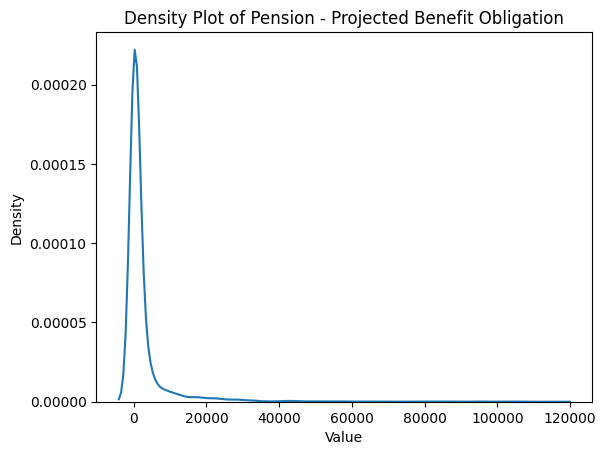

In [108]:
import seaborn as sns

sns.kdeplot(df_analysis_decritive["Pension - Projected Benefit Obligation"])
plt.title('Density Plot of Pension - Projected Benefit Obligation')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


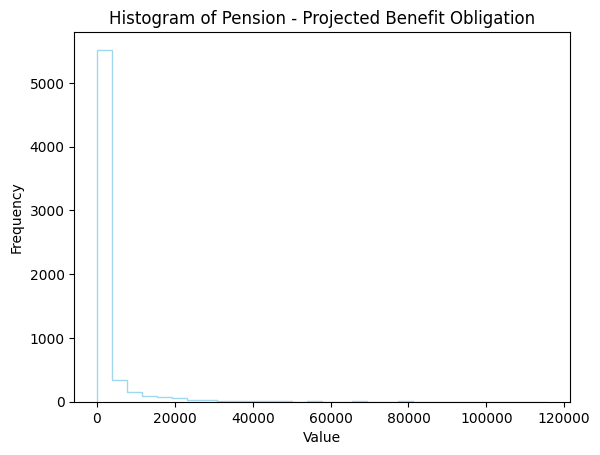

In [113]:
df_analysis_decritive["Pension - Projected Benefit Obligation"].plot(kind='hist', bins=30, color='skyblue', alpha=0.8, histtype='step')

# 设置图表属性
plt.title('Histogram of Pension - Projected Benefit Obligation')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示图表
plt.show()


In [109]:
df1

,Pension - Accumulated Benefit Obligation,Pension - Long-Term Asset,Pension Actual Return on Plan Assets,Pension Beginning Plan Assets,Pension Employer Contribution,Employer Contributions - Expected Next Year,Pension - Current Liability,Pension Benefits Paid,Pension - Projected Benefit Obligation,Pension Plans - Interest Cost,...,Postretirement - Long-Term Liability,Postretirement Other Adjustments (Plan Assets),Postretirement Other Adjustments (Net Benefit Asset/Liability),Postretirement Net Total Other Costs,Postretirement Benefits Paid,Postretirement Participant Contributions,Postretirement Prior Service,Postretirement Service Cost,Global Company Key,Record_Date
0,151.900000,0.000,8.600,129.900,0.400,3.100000,0.400000,7.100,159.100,3.800,...,0.400000,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2020-05-31
1,153.000000,10.400,23.800,131.800,2.700,2.300000,0.400000,6.800,159.000,3.100,...,178.892536,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2021-05-31
2,116.500000,9.700,-16.700,158.400,0.500,0.300000,0.300000,7.600,120.200,3.100,...,178.892536,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2022-05-31
3,105.300000,8.700,-7.400,126.200,0.300,0.400000,0.200000,5.800,108.000,3.300,...,178.892536,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2023-05-31
4,2007.997043,0.000,0.643,5.819,0.300,40.814273,0.000000,0.525,8.662,0.319,...,0.072000,0.000000,0.038000,0.003000,0.017000,0.000000,0.00000,0.000000,1019,2019-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6383,2007.997043,9.099,369.631,6419.067,255.898,456.068000,0.000000,194.483,9042.877,109.183,...,706.279000,0.000000,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2021-12-31
6384,2007.997043,49.162,-1062.329,6528.946,339.860,241.536000,0.000000,203.061,6308.785,140.005,...,594.221000,0.000000,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2022-12-31
6385,2007.997043,14.895,-2.709,897.768,40.624,37.915000,7.044455,24.374,1113.070,1.354,...,135.410000,0.642125,-0.089208,0.000000,18.182696,0.000000,-18.60939,10.833000,353444,2021-12-31
6386,2007.997043,30.123,-150.612,819.332,33.737,28.918000,7.044455,49.401,778.365,1.205,...,101.212000,0.642125,-0.089208,0.000000,18.182696,0.000000,-18.60939,8.434000,353444,2022-12-31


In [110]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6388 entries, 0 to 6387
Data columns (total 34 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Pension - Accumulated Benefit Obligation                             6388 non-null   float64
 1   Pension - Long-Term Asset                                            6388 non-null   float64
 2   Pension Actual Return on Plan Assets                                 6388 non-null   float64
 3   Pension Beginning Plan Assets                                        6388 non-null   float64
 4   Pension Employer Contribution                                        6388 non-null   float64
 5   Employer Contributions - Expected Next Year                          6388 non-null   float64
 6   Pension - Current Liability                                          6388 non-null   float64
 7   Pensio

In [153]:
df_analysis_decritive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6385 entries, 0 to 6384
Data columns (total 36 columns):
 #   Column                                                               Non-Null Count  Dtype         
---  ------                                                               --------------  -----         
 0   Pension - Accumulated Benefit Obligation                             6385 non-null   float64       
 1   Pension - Long-Term Asset                                            6385 non-null   float64       
 2   Pension Actual Return on Plan Assets                                 6385 non-null   float64       
 3   Pension Beginning Plan Assets                                        6385 non-null   float64       
 4   Pension Employer Contribution                                        6385 non-null   float64       
 5   Employer Contributions - Expected Next Year                          6385 non-null   float64       
 6   Pension - Current Liability                     

In [161]:
df_analysis_decritive[df_analysis_decritive["GIC Groups"] == "Capital Goods"]

,Pension - Accumulated Benefit Obligation,Pension - Long-Term Asset,Pension Actual Return on Plan Assets,Pension Beginning Plan Assets,Pension Employer Contribution,Employer Contributions - Expected Next Year,Pension - Current Liability,Pension Benefits Paid,Pension - Projected Benefit Obligation,Pension Plans - Interest Cost,...,Postretirement Other Adjustments (Net Benefit Asset/Liability),Postretirement Net Total Other Costs,Postretirement Benefits Paid,Postretirement Participant Contributions,Postretirement Prior Service,Postretirement Service Cost,Global Company Key,Record_Date,GIC Groups,year
0,151.900000,0.000,8.600,129.900,0.400,3.100,0.400000,7.100,159.100,3.800,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2020-05-31,Capital Goods,2020
1,153.000000,10.400,23.800,131.800,2.700,2.300,0.400000,6.800,159.000,3.100,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2021-05-31,Capital Goods,2021
2,116.500000,9.700,-16.700,158.400,0.500,0.300,0.300000,7.600,120.200,3.100,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2022-05-31,Capital Goods,2022
3,105.300000,8.700,-7.400,126.200,0.300,0.400,0.200000,5.800,108.000,3.300,...,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2023-05-31,Capital Goods,2023
62,24000.000000,3265.000,4321.000,23590.000,107.000,112.000,45.000000,1380.000,24180.000,755.000,...,-20.000000,-62.000000,0.000000,0.000000,-166.00000,0.000000,1300,2019-12-31,Capital Goods,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6378,2007.997043,0.000,-58.781,345.205,14.962,8.550,7.044455,13.894,412.535,5.344,...,-34.200000,0.000000,0.000000,0.000000,0.00000,5.344000,351491,2022-12-31,Capital Goods,2022
6379,2007.997043,4.822,501.441,6380.108,272.417,723.232,0.000000,182.012,10312.078,165.138,...,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2020-12-31,Capital Goods,2020
6380,2007.997043,9.099,369.631,6419.067,255.898,456.068,0.000000,194.483,9042.877,109.183,...,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2021-12-31,Capital Goods,2021
6381,2007.997043,49.162,-1062.329,6528.946,339.860,241.536,0.000000,203.061,6308.785,140.005,...,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2022-12-31,Capital Goods,2022


In [166]:
df_grouped = df_analysis_decritive.groupby(["GIC Groups","year"])["Pension - Projected Benefit Obligation"].mean()
print(df_grouped)
df_analysis_decritive.set_index(["GIC Groups","year","Global Company Key"]).assign(group_level_PBO=df_grouped)\
[["group_level_PBO",\
   "Pension - Projected Benefit Obligation",\
  "Pension Plans - Return on Plan Assets (Expected)",\
  "Postretirement Employer Contributions"]].head(20)

GIC Groups                 year
Automobile and Components  2019    11442.671448
                           2020    11888.488784
                           2021     9988.316105
                           2022     8268.847944
                           2023     8428.561333
                                       ...     
Utilities                  2019     2677.205192
                           2020     2827.575274
                           2021     2623.624358
                           2022     2043.739308
                           2023     1442.937500
Name: Pension - Projected Benefit Obligation, Length: 123, dtype: float64


group_level_PBO  \
GIC Groups                       year Global Company Key                    
Capital Goods                    2020 1004                    3778.704469   
                                 2021 1004                    3583.277420   
                                 2022 1004                    2547.194355   
                                 2023 1004                    1083.915600   
Busniess and Professional        2019 1019                     669.358020   
                                 2020 1019                     616.183328   
Transportation                   2019 1045                    6199.937805   
                                 2020 1045                    7354.364465   
                                 2021 1045                    6515.615182   
                                 2022 1045                    4625.853239   
Busniess and Professional        2019 1050                     669.358020   
                                 2020 1050                     616.183328   
                                 2021 1050                     601.975581   
                                 2022 1050                     425.765105   
Utilities                        2019 1075                    2677.205192   
                                 2020 1075                    2827.575274   
                                 2021 1075                    2623.624358   
                                 2022 1075                    2043.739308   
Health Care Equipment & Services 2019 1078                    1169.318649   
                                 2020 1078                    1119.828113   

                                                          Pension - Projected Benefit Obligation  \
GIC Groups                       year Global Company Key                                           
Capital Goods                    2020 1004                                               159.100   
                                 2021 1004                                               159.000   
                                 2022 1004                                               120.200   
                                 2023 1004                                               108.000   
Busniess and Professional        2019 1019                                                 8.662   
                                 2020 1019                                                 9.155   
Transportation                   2019 1045                                             18358.000   
                                 2020 1045                                             19812.000   
                                 2021 1045                                             18910.000   
                                 2022 1045                                             14037.000   
Busniess and Professional        2019 1050                                                35.985   
                                 2020 1050                                                38.272   
                                 2021 1050                                                35.035   
                                 2022 1050                                                27.350   
Utilities                        2019 1075                                              3613.114   
                                 2020 1075                                              3902.867   
                                 2021 1075                                              3716.824   
                                 2022 1075                                              2809.529   
Health Care Equipment & Services 2019 1078                                             11238.000   
                                 2020 1078                                             13129.000   

                                                          Pension Plans - Return on Plan Assets (Expected)  \
GIC Groups                       year Global Company

In [149]:
df_grouped = df_analysis_decritive.groupby(["GIC Groups","Global Company Key","year"])["Pension - Projected Benefit Obligation"].mean()
df_analysis_decritive.set_index(["GIC Groups","Global Company Key","year"]).assign(group_level=df_grouped)

Pension - Accumulated Benefit Obligation  \
GIC Groups                    Global Company Key year                                             
Capital Goods                 1004               2020                                151.900000   
                                                 2021                                153.000000   
                                                 2022                                116.500000   
                                                 2023                                105.300000   
Busniess and Professional     1019               2019                               2007.997043   
...                                                                                         ...   
Capital Goods                 351590             2021                               2007.997043   
                                                 2022                               2007.997043   
Household & Personal Products 353444             2021                               2007.997043   
                                                 2022                               2007.997043   
Capital Goods                 353945             2022                                360.239000   

                                                       Pension - Long-Term Asset  \
GIC Groups                    Global Company Key year                              
Capital Goods                 1004               2020                      0.000   
                                                 2021                     10.400   
                                                 2022                      9.700   
                                                 2023                      8.700   
Busniess and Professional     1019               2019                      0.000   
...                                                                          ...   
Capital Goods                 351590             2021                      9.099   
                                                 2022                     49.162   
Household & Personal Products 353444             2021                     14.895   
                                                 2022                     30.123   
Capital Goods                 353945             2022                     77.017   

                                                       Pension Actual Return on Plan Assets  \
GIC Groups                    Global Company Key year                                         
Capital Goods                 1004               2020                                 8.600   
                                                 2021                                23.800   
                                                 2022                               -16.700   
                                                 2023                                -7.400   
Busniess and Professional     1019               2019                                 0.643   
...                                                                                     ...   
Capital Goods                 351590             2021                               369.631   
                                                 2022                             -1062.329   
Household & Personal Products 353444             2021                                -2.709   
                                                 2022                              -150.612   
Capital Goods                 353945             2022                                -5.786   

                                                       Pension Beginning Plan Assets  \
GIC Groups                    Global Company Key year                                  
Capital Goods                 1004               2020                        129.900   
                                                 2021                        131.800   
                                                 2022                        158.400  

In [136]:
# data_x_fixed_effect = data_x_fixed_effect.set_index(["","Global Company Key","year"])

Pension - Accumulated Benefit Obligation  \
Global Company Key year                                             
1004               2020                                151.900000   
                   2021                                153.000000   
                   2022                                116.500000   
                   2023                                105.300000   
1019               2019                               2007.997043   
...                                                           ...   
351590             2021                               2007.997043   
                   2022                               2007.997043   
353444             2021                               2007.997043   
                   2022                               2007.997043   
353945             2022                                360.239000   

                         Pension - Long-Term Asset  \
Global Company Key year                              
1004               2020                      0.000   
                   2021                     10.400   
                   2022                      9.700   
                   2023                      8.700   
1019               2019                      0.000   
...                                            ...   
351590             2021                      9.099   
                   2022                     49.162   
353444             2021                     14.895   
                   2022                     30.123   
353945             2022                     77.017   

                         Pension Actual Return on Plan Assets  \
Global Company Key year                                         
1004               2020                                 8.600   
                   2021                                23.800   
                   2022                               -16.700   
                   2023                                -7.400   
1019               2019                                 0.643   
...                                                       ...   
351590             2021                               369.631   
                   2022                             -1062.329   
353444             2021                                -2.709   
                   2022                              -150.612   
353945             2022                                -5.786   

                         Pension Beginning Plan Assets  \
Global Company Key year                                  
1004               2020                        129.900   
                   2021                        131.800   
                   2022                        158.400   
                   2023                        126.200   
1019               2019                          5.819   
...                                                ...   
351590             2021                       6419.067   
                   2022                       6528.946   
353444             2021                        897.768   
                   2022                        819.332   
353945             2022                        429.225   

                         Pension Employer Contribution  \
Global Company Key year                                  
1004               2020                          0.400   
                   2021                          2.700   
                   2022                          0.500   
                   2023                          0.300   
1019               2019                          0.300   
...                                                ...   
351590             2021                        255.898   
                   2022                        339.860   
353444             2021                         40.624   
                   2022                         33.737   
353945             2022                          6.407   

                         Employer Contributions - Expected Next Year

In [111]:
data_x_fixed_effect = df1.copy()
import datetime  # 将日期列分解成年、月、日
data_x_fixed_effect['Record_Date']=pd.to_datetime(data_x_fixed_effect['Record_Date'])
data_x_fixed_effect['year'] = data_x_fixed_effect["Record_Date"].dt.year
data_x_fixed_effect = data_x_fixed_effect.set_index(["Global Company Key","year"])
data_x_fixed_effect = data_x_fixed_effect.drop("Record_Date",axis=1)
data_x_fixed_effect.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6388 entries, ('1004', 2020) to ('353945', 2022)
Data columns (total 32 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Pension - Accumulated Benefit Obligation                             6388 non-null   float64
 1   Pension - Long-Term Asset                                            6388 non-null   float64
 2   Pension Actual Return on Plan Assets                                 6388 non-null   float64
 3   Pension Beginning Plan Assets                                        6388 non-null   float64
 4   Pension Employer Contribution                                        6388 non-null   float64
 5   Employer Contributions - Expected Next Year                          6388 non-null   float64
 6   Pension - Current Liability                                          6388 non-n

In [112]:
df1["Global Company Key"].value_counts()
# data_x_fixed_effect['Global Company Key'].value_counts()

Global Company Key
1004      4
33809     4
35056     4
34939     4
34636     4
         ..
25848     1
13997     1
14163     1
4467      1
353945    1
Name: count, Length: 1784, dtype: int64

In [113]:
df1

,Pension - Accumulated Benefit Obligation,Pension - Long-Term Asset,Pension Actual Return on Plan Assets,Pension Beginning Plan Assets,Pension Employer Contribution,Employer Contributions - Expected Next Year,Pension - Current Liability,Pension Benefits Paid,Pension - Projected Benefit Obligation,Pension Plans - Interest Cost,...,Postretirement - Long-Term Liability,Postretirement Other Adjustments (Plan Assets),Postretirement Other Adjustments (Net Benefit Asset/Liability),Postretirement Net Total Other Costs,Postretirement Benefits Paid,Postretirement Participant Contributions,Postretirement Prior Service,Postretirement Service Cost,Global Company Key,Record_Date
0,151.900000,0.000,8.600,129.900,0.400,3.100000,0.400000,7.100,159.100,3.800,...,0.400000,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2020-05-31
1,153.000000,10.400,23.800,131.800,2.700,2.300000,0.400000,6.800,159.000,3.100,...,178.892536,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2021-05-31
2,116.500000,9.700,-16.700,158.400,0.500,0.300000,0.300000,7.600,120.200,3.100,...,178.892536,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2022-05-31
3,105.300000,8.700,-7.400,126.200,0.300,0.400000,0.200000,5.800,108.000,3.300,...,178.892536,0.642125,-0.089208,-8.893765,18.182696,2.344157,-18.60939,4.729807,1004,2023-05-31
4,2007.997043,0.000,0.643,5.819,0.300,40.814273,0.000000,0.525,8.662,0.319,...,0.072000,0.000000,0.038000,0.003000,0.017000,0.000000,0.00000,0.000000,1019,2019-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6383,2007.997043,9.099,369.631,6419.067,255.898,456.068000,0.000000,194.483,9042.877,109.183,...,706.279000,0.000000,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2021-12-31
6384,2007.997043,49.162,-1062.329,6528.946,339.860,241.536000,0.000000,203.061,6308.785,140.005,...,594.221000,0.000000,-0.089208,-8.893765,0.000000,0.000000,-18.60939,4.729807,351590,2022-12-31
6385,2007.997043,14.895,-2.709,897.768,40.624,37.915000,7.044455,24.374,1113.070,1.354,...,135.410000,0.642125,-0.089208,0.000000,18.182696,0.000000,-18.60939,10.833000,353444,2021-12-31
6386,2007.997043,30.123,-150.612,819.332,33.737,28.918000,7.044455,49.401,778.365,1.205,...,101.212000,0.642125,-0.089208,0.000000,18.182696,0.000000,-18.60939,8.434000,353444,2022-12-31


In [114]:
nul_columns = data_x_fixed_effect.select_dtypes(include=['float64','int64']).columns
column_name = []
unique_value = []
for col_temp in nul_columns:
    #print(col, data[col].nunique())
    column_name.append(col_temp)
    # unique_value.append(data[col_temp].nunique())
print(column_name)
print(len(column_name))


filled_out_list = ['Pension - Projected Benefit Obligation','Pension - Accumulated Benefit Obligation','Postretirement Benefit Obligation'] #Postretirement Benefit Obligation
r = list(set(column_name).difference(filled_out_list)) # 求特定1个list(a)中有，其他list(b、c)都没有的元素"""
print(r)
print(len(r))

['Pension - Accumulated Benefit Obligation', 'Pension - Long-Term Asset', 'Pension Actual Return on Plan Assets', 'Pension Beginning Plan Assets', 'Pension Employer Contribution', 'Employer Contributions - Expected Next Year', 'Pension - Current Liability', 'Pension Benefits Paid', 'Pension - Projected Benefit Obligation', 'Pension Plans - Interest Cost', 'Pension Plan Assets', 'Pension Plans - Other Periodic Cost Components (Net)', 'Periodic Postretirement Benefit Cost (Net)', 'Pension Plans - Rate of Compensation Increase', 'Pension Plans - Anticipated Long-Term Rate of Return on Plan Assets', 'Pension Plans - Return on Plan Assets (Expected)', 'Pension Plans - Service Cost', 'Postretirement - Long-Term Asset', 'Post Retirement Actual Return on Plan Assets', 'Postretirement Benefit Asset', 'Postretirement Benefit Obligation', 'Postretirement Employer Contributions', 'Postretirement Interest Cost', 'Postretirement - Current Liability', 'Postretirement - Long-Term Liability', 'Postreti

# Building Model - Fixed Effect Model - Considering entity_effect & time effect

使用固定效应model

使用get_robustcov_results函数获取heteroscedasticity-robust covariance matrix和White标准误差

## Regression Analysis - PanelOLS Estimation

In [132]:
data_x_fixed_effect

Pension - Accumulated Benefit Obligation  \
Global Company Key year                                             
1004               2020                                151.900000   
                   2021                                153.000000   
                   2022                                116.500000   
                   2023                                105.300000   
1019               2019                               2007.997043   
...                                                           ...   
351590             2021                               2007.997043   
                   2022                               2007.997043   
353444             2021                               2007.997043   
                   2022                               2007.997043   
353945             2022                                360.239000   

                         Pension - Long-Term Asset  \
Global Company Key year                              
1004               2020                      0.000   
                   2021                     10.400   
                   2022                      9.700   
                   2023                      8.700   
1019               2019                      0.000   
...                                            ...   
351590             2021                      9.099   
                   2022                     49.162   
353444             2021                     14.895   
                   2022                     30.123   
353945             2022                     77.017   

                         Pension Actual Return on Plan Assets  \
Global Company Key year                                         
1004               2020                                 8.600   
                   2021                                23.800   
                   2022                               -16.700   
                   2023                                -7.400   
1019               2019                                 0.643   
...                                                       ...   
351590             2021                               369.631   
                   2022                             -1062.329   
353444             2021                                -2.709   
                   2022                              -150.612   
353945             2022                                -5.786   

                         Pension Beginning Plan Assets  \
Global Company Key year                                  
1004               2020                        129.900   
                   2021                        131.800   
                   2022                        158.400   
                   2023                        126.200   
1019               2019                          5.819   
...                                                ...   
351590             2021                       6419.067   
                   2022                       6528.946   
353444             2021                        897.768   
                   2022                        819.332   
353945             2022                        429.225   

                         Pension Employer Contribution  \
Global Company Key year                                  
1004               2020                          0.400   
                   2021                          2.700   
                   2022                          0.500   
                   2023                          0.300   
1019               2019                          0.300   
...                                                ...   
351590             2021                        255.898   
                   2022                        339.860   
353444             2021                         40.624   
                   2022                         33.737   
353945             2022                          6.407   

                         Employer Contributions - Expected Next Year

In [115]:
import numpy as np
import linearmodels as plm
import scipy.stats as stats
import pandas as pd
from linearmodels import RandomEffects
import statsmodels.api as sm
# reg_fe = plm.PanelOLS.from_formula(formula='ltvfo ~1 +ltlan + ltwlab + ltpow + ltfer + hrs + mci+ ngca + EntityEffects',data=lin)
# results_fe = reg_fe.fit()
from linearmodels.panel import PanelOLS

exog_vars=r
exog=data_x_fixed_effect[exog_vars]
exog=sm.add_constant(data_x_fixed_effect[exog_vars])
data_y=data_x_fixed_effect["Pension - Projected Benefit Obligation"]
reg_fe=PanelOLS(data_y, exog,entity_effects=True,time_effects=True)#entity_effects=True,time_effects=True
results_fe = reg_fe.fit(cov_type='clustered',use_lsdv=True, cluster_entity=True, cluster_time=True)
# 获取heteroscedasticity-robust covariance matrix和White标准误差
# robust_results = results_fe.get_robustcov_results()
# 输出参数估计值和White标准误差
# print(robust_results.summary())
# results_fe = reg_fe.fit()
print(results_fe)
# print(results_fe.summary.as_csv())


                                    PanelOLS Estimation Summary                                     
Dep. Variable:     Pension - Projected Benefit Obligation   R-squared:                        0.8939
Estimator:                                       PanelOLS   R-squared (Between):              0.9745
No. Observations:                                    6388   R-squared (Within):               0.9002
Date:                                    Sat, Nov 25 2023   R-squared (Overall):              0.9729
Time:                                            00:23:49   Log-likelihood                -4.803e+04
Cov. Estimator:                                 Clustered                                           
                                                            F-statistic:                      1327.6
Entities:                                            1784   P-value                           0.0000
Avg Obs:                                           3.5807   Distribution:                 F

In [117]:
data_x_fixed_effect

Pension - Accumulated Benefit Obligation  \
Global Company Key year                                             
1004               2020                                151.900000   
                   2021                                153.000000   
                   2022                                116.500000   
                   2023                                105.300000   
1019               2019                               2007.997043   
...                                                           ...   
351590             2021                               2007.997043   
                   2022                               2007.997043   
353444             2021                               2007.997043   
                   2022                               2007.997043   
353945             2022                                360.239000   

                         Pension - Long-Term Asset  \
Global Company Key year                              
1004               2020                      0.000   
                   2021                     10.400   
                   2022                      9.700   
                   2023                      8.700   
1019               2019                      0.000   
...                                            ...   
351590             2021                      9.099   
                   2022                     49.162   
353444             2021                     14.895   
                   2022                     30.123   
353945             2022                     77.017   

                         Pension Actual Return on Plan Assets  \
Global Company Key year                                         
1004               2020                                 8.600   
                   2021                                23.800   
                   2022                               -16.700   
                   2023                                -7.400   
1019               2019                                 0.643   
...                                                       ...   
351590             2021                               369.631   
                   2022                             -1062.329   
353444             2021                                -2.709   
                   2022                              -150.612   
353945             2022                                -5.786   

                         Pension Beginning Plan Assets  \
Global Company Key year                                  
1004               2020                        129.900   
                   2021                        131.800   
                   2022                        158.400   
                   2023                        126.200   
1019               2019                          5.819   
...                                                ...   
351590             2021                       6419.067   
                   2022                       6528.946   
353444             2021                        897.768   
                   2022                        819.332   
353945             2022                        429.225   

                         Pension Employer Contribution  \
Global Company Key year                                  
1004               2020                          0.400   
                   2021                          2.700   
                   2022                          0.500   
                   2023                          0.300   
1019               2019                          0.300   
...                                                ...   
351590             2021                        255.898   
                   2022                        339.860   
353444             2021                         40.624   
                   2022                         33.737   
353945             2022                          6.407   

                         Employer Contributions - Expected Next Year

In [91]:
len(exog_vars)

29

## Residual Plot

In [92]:
results_fe.resids

Global Company Key  year
1004                2020   -9.375297e+01
                    2021    6.078666e+00
                    2022   -1.386695e+01
                    2023    1.015413e+02
1019                2019    3.208127e+01
                                ...     
351590              2021    1.921976e+01
                    2022   -9.749015e+02
353444              2021    3.106341e+01
                    2022   -3.106341e+01
353945              2022   -3.637979e-12
Name: residual, Length: 6388, dtype: float64

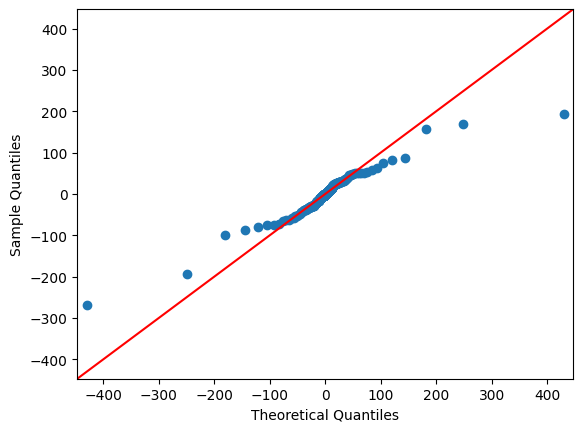

In [93]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib import pyplot as plt
# >>> data = sm.datasets.longley.load()
# >>> exog = sm.add_constant(data.exog)
# >>> mod_fit = sm.OLS(data.endog, exog).fit()
res = results_fe.resids # residuals
fig = sm.qqplot(res, stats.t, fit=True, line="45")
plt.show()

In [94]:
results_fe.model

PanelOLS 
Num exog: 30, Constant: True
Entity Effects: True, Time Effects: True, Num Other Effects: 0
id: 0x17915563220

In [37]:
# import statsmodels.api as sm
# from statsmodels.stats.anova import anova_lm
# from statsmodels.formula.api import ols

# data_y=data_x_fixed_effect["Pension - Projected Benefit Obligation"]
# data_x=sm.add_constant(data_x_fixed_effect[exog_vars])
# mod=sm.OLS(data_y,data_x) # 需要用sm.add_constant 手动添加截距项
# # res=mod.fit()
# # print(res.summary())
# anova_table=anova_lm(mod)# anova_lm（）函数创建模型生成方差分析表
# print(anova_table)

## Minus the number of explain variable - Using Package
Recursive Feature Elimination(RFE)

In [95]:
import numpy as np
from numpy import mean
from numpy import std 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV,RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

In [96]:
# 1.Set up dataset
columns = exog_vars
X = data_x_fixed_effect[exog_vars]
X = StandardScaler().fit_transform(X)
y = data_x_fixed_effect["Pension - Projected Benefit Obligation"]

In [97]:
class RandomForestClassifierWithCoef(RandomForestClassifier):
    def fit(self, *args, **kwargs):
        super(RandomForestClassifierWithCoef, self).fit(*args, **kwargs)
        self.coef_= self.feature_importances_

In [98]:
rff = DecisionTreeRegressor()

In [99]:
# 2.Input Model;Select the number that we want to keep for the feature: output each features' rankings
# rf = RandomForestClassifierWithCoef(n_estimators=500, min_samples_leaf=5, n_jobs=-1)
# 'RandomForestClassifier 没有属性 coef，将RandomForestClassifier改进以适用于RFECV所做的工作'
# rf = RandomForestClassifierWithCoef(n_estimators=500, min_samples_leaf=5, n_jobs=-1)
rfe = RFE(rff, n_features_to_select=15) #
rfe.fit(X,y)

# 3.output each features' importance, we can just observe the ranking 
ranks = {} 
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0] # 1表示最重要
    ranks = map(lambda x: round(x,2), ranks)
    return zip(names, ranks)
fea_imp = ranking(list(map(float, rfe.ranking_)), columns, order=-1)

In [100]:
list(fea_imp)

[('Post Retirement Actual Return on Plan Assets', 0.21),
 ('Pension Plans - Rate of Compensation Increase', 1.0),
 ('Pension Plans - Service Cost', 1.0),
 ('Postretirement - Current Liability', 0.79),
 ('Postretirement - Long-Term Asset', 0.07),
 ('Pension Beginning Plan Assets', 1.0),
 ('Pension Plan Assets', 1.0),
 ('Pension Plans - Other Periodic Cost Components (Net)', 1.0),
 ('Pension Actual Return on Plan Assets', 0.71),
 ('Employer Contributions - Expected Next Year', 1.0),
 ('Pension Plans - Anticipated Long-Term Rate of Return on Plan Assets', 1.0),
 ('Postretirement - Long-Term Liability', 0.0),
 ('Pension - Long-Term Asset', 1.0),
 ('Periodic Postretirement Benefit Cost (Net)', 0.57),
 ('Pension Employer Contribution', 0.93),
 ('Postretirement Net Total Other Costs', 0.36),
 ('Postretirement Benefit Asset', 1.0),
 ('Postretirement Participant Contributions', 0.14),
 ('Postretirement Other Adjustments (Plan Assets)', 1.0),
 ('Postretirement Other Adjustments (Net Benefit Asse

In [102]:
rfe.ranking_
dicisions = rfe.support_
reduced_feature_list = [number for number, b in zip(columns, dicisions) if b == True]
[number for number, b in zip(columns, dicisions) if b == True]

['Pension Plans - Rate of Compensation Increase',
 'Pension Plans - Service Cost',
 'Pension Beginning Plan Assets',
 'Pension Plan Assets',
 'Pension Plans - Other Periodic Cost Components (Net)',
 'Employer Contributions - Expected Next Year',
 'Pension Plans - Anticipated Long-Term Rate of Return on Plan Assets',
 'Pension - Long-Term Asset',
 'Postretirement Benefit Asset',
 'Postretirement Other Adjustments (Plan Assets)',
 'Postretirement Other Adjustments (Net Benefit Asset/Liability)',
 'Pension Plans - Return on Plan Assets (Expected)',
 'Postretirement Interest Cost',
 'Pension Plans - Interest Cost',
 'Pension Benefits Paid']

In [103]:
import numpy as np
import linearmodels as plm
import scipy.stats as stats
import pandas as pd
from linearmodels import RandomEffects
import statsmodels.api as sm
# reg_fe = plm.PanelOLS.from_formula(formula='ltvfo ~1 +ltlan + ltwlab + ltpow + ltfer + hrs + mci+ ngca + EntityEffects',data=lin)
# results_fe = reg_fe.fit()
from linearmodels.panel import PanelOLS

# exog_vars=r
exog_new=data_x_fixed_effect[reduced_feature_list]
exog_new=sm.add_constant(exog_new)
data_y=data_x_fixed_effect["Pension - Projected Benefit Obligation"]
reg_fe_new=PanelOLS(data_y, exog_new,entity_effects=True,time_effects=True)#entity_effects=True,time_effects=True
results_fe_new = reg_fe_new.fit(cov_type='clustered',use_lsdv=True, cluster_entity=True, cluster_time=True)
# 获取heteroscedasticity-robust covariance matrix和White标准误差
# robust_results = results_fe.get_robustcov_results()
# 输出参数估计值和White标准误差
# print(robust_results.summary())
# results_fe = reg_fe.fit()
print(results_fe_new)
# print(results_fe.summary.as_csv())

                                    PanelOLS Estimation Summary                                     
Dep. Variable:     Pension - Projected Benefit Obligation   R-squared:                        0.8810
Estimator:                                       PanelOLS   R-squared (Between):              0.9686
No. Observations:                                    6388   R-squared (Within):               0.8880
Date:                                    Wed, Nov 22 2023   R-squared (Overall):              0.9674
Time:                                            19:20:34   Log-likelihood                -4.839e+04
Cov. Estimator:                                 Clustered                                           
                                                            F-statistic:                      2262.7
Entities:                                            1784   P-value                           0.0000
Avg Obs:                                           3.5807   Distribution:                 F

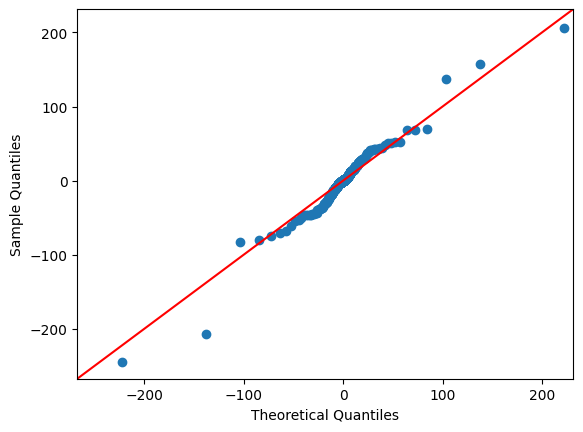

In [104]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib import pyplot as plt
# >>> data = sm.datasets.longley.load()
# >>> exog = sm.add_constant(data.exog)
# >>> mod_fit = sm.OLS(data.endog, exog).fit()
res = results_fe_new.resids # residuals
fig = sm.qqplot(res, stats.t, fit=True, line="45")
plt.show()

In [16]:
from sklearn.linear_model import Ridge


skridge = Ridge(alpha=0.2, max_iter=9000, tol=1e-5, fit_intercept=True)

exog=sm.add_constant(data_x_fixed_effect[exog_vars])
data_y=data_x_fixed_effect["Pension - Projected Benefit Obligation"]

skridge.fit(exog,data_y)
result = regression_analysis(exog, data_y, skridge)
# result.summary()
type(skridge)

sklearn.linear_model._ridge.Ridge

In [145]:
import numpy as np
import linearmodels as plm
import scipy.stats as stats
import pandas as pd

from linearmodels import RandomEffects
import statsmodels.api as sm

exog_vars=r
exog=sm.add_constant(data_x_fixed_effect[exog_vars])
data_y=data_x_fixed_effect["Pension - Projected Benefit Obligation"]
reg_re=RandomEffects(data_y,exog)
results_re1=reg_re.fit()
print(results_re1)

                                  RandomEffects Estimation Summary                                  
Dep. Variable:     Pension - Projected Benefit Obligation   R-squared:                        0.9512
Estimator:                                  RandomEffects   R-squared (Between):              0.9774
No. Observations:                                    6388   R-squared (Within):               0.8986
Date:                                    Fri, Nov 10 2023   R-squared (Overall):              0.9758
Time:                                            18:24:26   Log-likelihood                 -4.93e+04
Cov. Estimator:                                Unadjusted                                           
                                                            F-statistic:                      4268.8
Entities:                                            1784   P-value                           0.0000
Avg Obs:                                           3.5807   Distribution:                 F

In [144]:
b_fe = results_fe.params
b_re = results_re1.params
b_diff = b_fe - b_re

v_fe = results_fe.cov
v_re = results_re1.cov
v_diff = v_fe - v_re
df = len(b_fe)

table = pd.DataFrame({'FE':b_fe,'RE':b_re,'Difference':b_diff,'sqrt(diag(v_fe-v_re))':np.sqrt(np.diag(v_diff))})
chi2 = np.dot(b_diff.T,  np.linalg.inv(v_diff).dot(b_diff))
pval = 1 - stats.chi2.cdf(chi2, df)

print(table)
print()
print(f'chi-Squared: {chi2:.2f}')
print(f'degrees of freedom: {df}')
print(f'p-Value:{pval:.5f}')

                                                           FE          RE  \
const                                               -1.291286 -124.075127   
Postretirement Benefits Paid                        -9.840686   -7.908148   
Post Retirement Actual Return on Plan Assets         0.085869    0.218306   
Postretirement Other Adjustments (Net Benefit A...   1.023963    0.876244   
Pension Plans - Rate of Compensation Increase      -14.486055  -43.625173   
Employer Contributions - Expected Next Year          0.839978    0.856100   
Pension Plan Assets                                  0.948919    0.955824   
Postretirement Service Cost                          3.864967    2.895763   
Postretirement Prior Service                        -0.758904   -1.069389   
Pension Plans - Return on Plan Assets (Expected)     0.701249    1.024753   
Pension Plans - Other Periodic Cost Components ...   0.306071    0.381306   
Postretirement Interest Cost                         2.457063    0.139638   

                                      OLS Regression Results                                      
Dep. Variable:     Pension - Projected Benefit Obligation   R-squared:                       0.978
Model:                                                OLS   Adj. R-squared:                  0.978
Method:                                     Least Squares   F-statistic:                     9314.
Date:                                    Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                                            21:14:28   Log-Likelihood:                -54243.
No. Observations:                                    6388   AIC:                         1.085e+05
Df Residuals:                                        6357   BIC:                         1.088e+05
Df Model:                                              30                                         
Covariance Type:                                nonrobust                                         
          

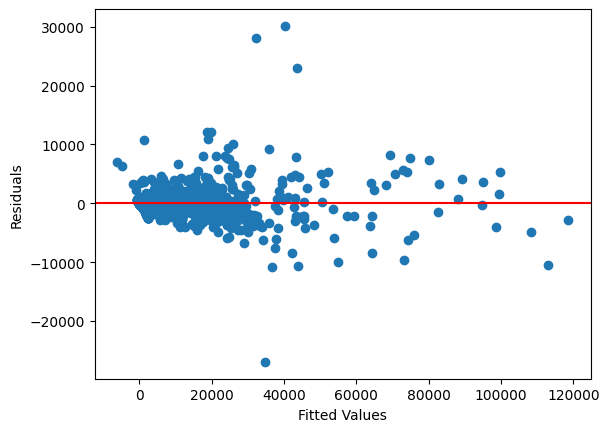

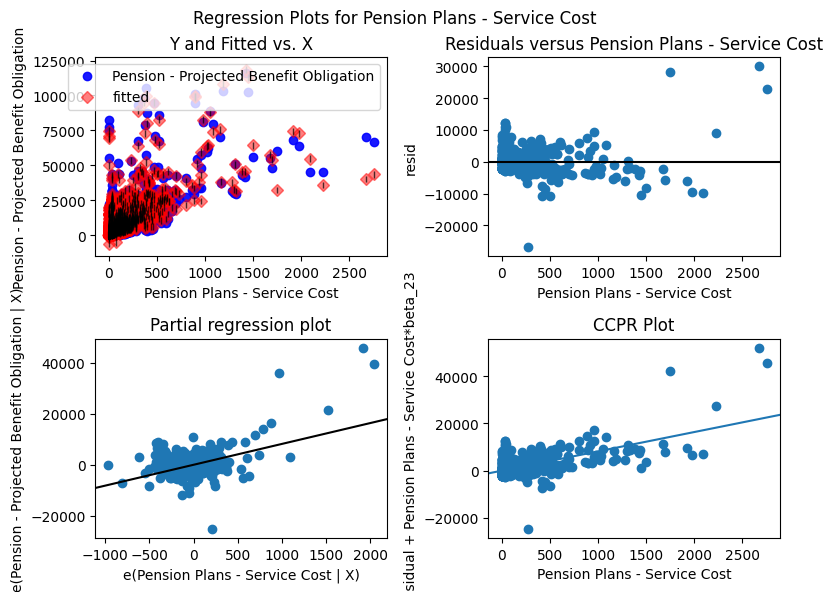

Lagrange multiplier statistic: 2090.191466565885
Lagrange multiplier p-value:   0.0
F-statistic:                   103.05521251580925
P-value of F-statistic:        0.0
Heteroscedasticity detected
Lagrange multiplier statistic: 6196.971370513766
Lagrange multiplier p-value:   0.0
F-statistic:                   386.1344669048783
P-value of F-statistic:        0.0
Rejected the null hypothesis. Heteroskedasticity detected


In [27]:
import statsmodels.api as sm
data_y=data_x_fixed_effect["Pension - Projected Benefit Obligation"]
data_x=sm.add_constant(data_x_fixed_effect[exog_vars])
mod=sm.OLS(data_y,data_x) # 需要用sm.add_constant 手动添加截距项
res=mod.fit()
print(res.summary())

import numpy as np
from plotnine import *
import statsmodels.api as sm
import pandas as pd

# from statsmodels.stats.diagnostic import het_white #怀特检验
# def white_test(res, X):
#     result_bp_test = sm.stats.diagnostic.het_white(res, X)
#     bp_lm_statistic = result_bp_test[0]
#     bp_lm_pval = result_bp_test[1]
#     bp_F_statistic= result_bp_test[2]
#     bp_F_pval = result_bp_test[3]
#     white_test_output=pd.Series(result_bp_test[0:4],index=['white_lm_statistic','white_lm_pval','white_F_statistic','white_F_pval'])    
#     return white_test_output
# white_test_output=white_test(res.resid,data_x['Postretirement Interest Cost'])
# print(white_test_output)


import matplotlib.pyplot as plt
# Plot fitted values vs. residuals to test for heteroskedasticity
plt.scatter(res.fittedvalues, res.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y = 0, color = 'r')
plt.show()

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,6))
# Create regression plots for specified X variable
sm.graphics.plot_regress_exog(res, 'Pension Plans - Service Cost', fig = fig)
plt.show()


# Test for heteroscedasticity using the Breusch-Pagan test
# NOTE: statsmodels refers to X variables as `exog` for exogenous
bp_lm, bp_lm_pvalue, bp_fvalue, bp_f_pvalue = sm.stats.diagnostic.het_breuschpagan(res.resid, res.model.exog)

print("Lagrange multiplier statistic: " + str(bp_lm))
print("Lagrange multiplier p-value:   " + str(bp_lm_pvalue))
print("F-statistic:                   " + str(bp_fvalue))
print("P-value of F-statistic:        " + str(bp_f_pvalue))

# If the p-value is less than the chosen significance level (e.g. 0.05), 
# reject the null hypothesis of homoscedasticity
if bp_lm_pvalue < 0.05:
    print("Heteroscedasticity detected")
else:
    print("No heteroscedasticity detected")


# Test for heteroskedasticity using the White test
# NOTE: statsmodels refers to X variables as `exog` for exogenous
lm, lm_pvalue, fvalue, f_pvalue = sm.stats.diagnostic.het_white(res.resid, res.model.exog)

print("Lagrange multiplier statistic: " + str(lm))
print("Lagrange multiplier p-value:   " + str(lm_pvalue))
print("F-statistic:                   " + str(fvalue))
print("P-value of F-statistic:        " + str(f_pvalue))

# If the p-value is less than the chosen significance level (e.g. 0.05), 
# reject the null hypothesis of homoscedasticity
if lm_pvalue < 0.05:
    print("Rejected the null hypothesis. Heteroskedasticity detected")
else:
    print("Failed to reject the null hypothesis. No heteroskedasticity detected.")

解决Model的 多重共线性问题

In [20]:
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import patsy


# data = pd.read_csv(r'e:\data\credit.csv',index_col=0)
# print('数据形状：',data.shape)
# print('\n数据示例：')
# data.head(10)
data = data_x_fixed_effect.copy()

In [21]:
# data.reset_index()
# data[exog_vars]

In [22]:
data["Pension - Projected Benefit Obligation"]

Global Company Key  year
1004                2020     159.100
                    2021     159.000
                    2022     120.200
                    2023     108.000
1019                2019       8.662
                              ...   
351590              2021    9042.877
                    2022    6308.785
353444              2021    1113.070
                    2022     778.365
353945              2022     376.482
Name: Pension - Projected Benefit Obligation, Length: 6388, dtype: float64

In [23]:
'''
使用里面的属性作为自变量，使用Projected Benefit Obligation做因变量
构建模型，即多个变量特征来预测。
对于超参数lambda，设定从10^(-2)到10^10次方超参数集等距挑选100个数进行测试。
'''
# X = data[['Income','Limit','Rating','Student']]
# y = data['Balance']
data_y=data["Pension - Projected Benefit Obligation"]
data_x=sm.add_constant(data[exog_vars])
###将因子变量映射成0,1
# X['Student'] = X['Student'].map({'Yes':1,'No':0})
###对数字变量进行标准化
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# formula = 'y~X'
# model=smf.ols(formula,data={'y':y,'X':X_scaled})

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(data_x)

model=sm.OLS(data_y,data_x) # 需要用sm.add_constant 手动添加截距项
# model=smf.ols(data_y,data_x)
result=model.fit()
print(result.summary())

                                      OLS Regression Results                                      
Dep. Variable:     Pension - Projected Benefit Obligation   R-squared:                       0.978
Model:                                                OLS   Adj. R-squared:                  0.978
Method:                                     Least Squares   F-statistic:                     9604.
Date:                                    Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                                            17:19:25   Log-Likelihood:                -54254.
No. Observations:                                    6388   AIC:                         1.086e+05
Df Residuals:                                        6358   BIC:                         1.088e+05
Df Model:                                              29                                         
Covariance Type:                                nonrobust                                         
          

In [24]:
mse = []###残差均方
###超参数的范围，100个，从10^-2到10^10
lam=10**np.linspace(-5,10,100)
###Statsmodels有一个岭回归和Lasso的简单实现即fit_regularized函数
for l in lam:
    ###L1_wt:0为岭回归；1为Lasso；0-1之间为ElasticNet算法
    result = model.fit_regularized(L1_wt=0,alpha=l,refit=True,profile_scale=False)
    ###使用原始数据进行预测
    pred=result.predict()
    ###计算残差均方
    mse.append(np.sum(data_y-pred)**2)

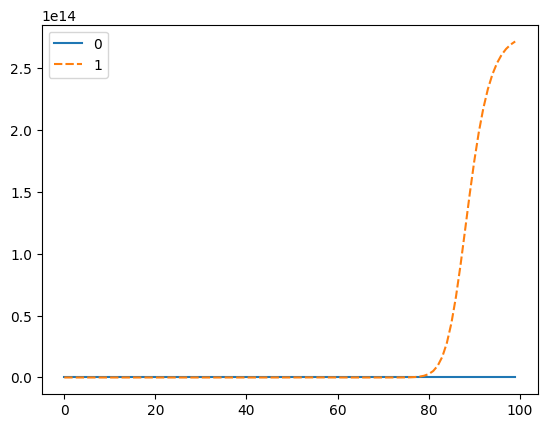

(0.4741829368423785, 1e-05)

In [25]:
pic_dt = np.arange(0,len(mse))
sns.lineplot(data=(pic_dt,mse))
plt.show()
lammin=lam[np.argmin(mse)]
# ###最小均方残差以及lambda超参数的值
np.min(mse),lammin

In [30]:
exog_vars

['Postretirement Benefits Paid',
 'Postretirement Interest Cost',
 'Employer Contributions - Expected Next Year',
 'Pension Actual Return on Plan Assets',
 'Postretirement Participant Contributions',
 'Postretirement Benefit Asset',
 'Pension Plans - Anticipated Long-Term Rate of Return on Plan Assets',
 'Postretirement - Long-Term Asset',
 'Pension Beginning Plan Assets',
 'Postretirement Other Adjustments (Plan Assets)',
 'Postretirement Other Adjustments (Net Benefit Asset/Liability)',
 'Pension Plans - Interest Cost',
 'Pension - Long-Term Asset',
 'Periodic Postretirement Benefit Cost (Net)',
 'Pension Employer Contribution',
 'Postretirement Net Total Other Costs',
 'Postretirement Prior Service',
 'Postretirement Service Cost',
 'Pension Plan Assets',
 'Post Retirement Actual Return on Plan Assets',
 'Pension - Current Liability',
 'Postretirement Employer Contributions',
 'Postretirement - Long-Term Liability',
 'Pension Plans - Service Cost',
 'Pension Plans - Return on Plan A

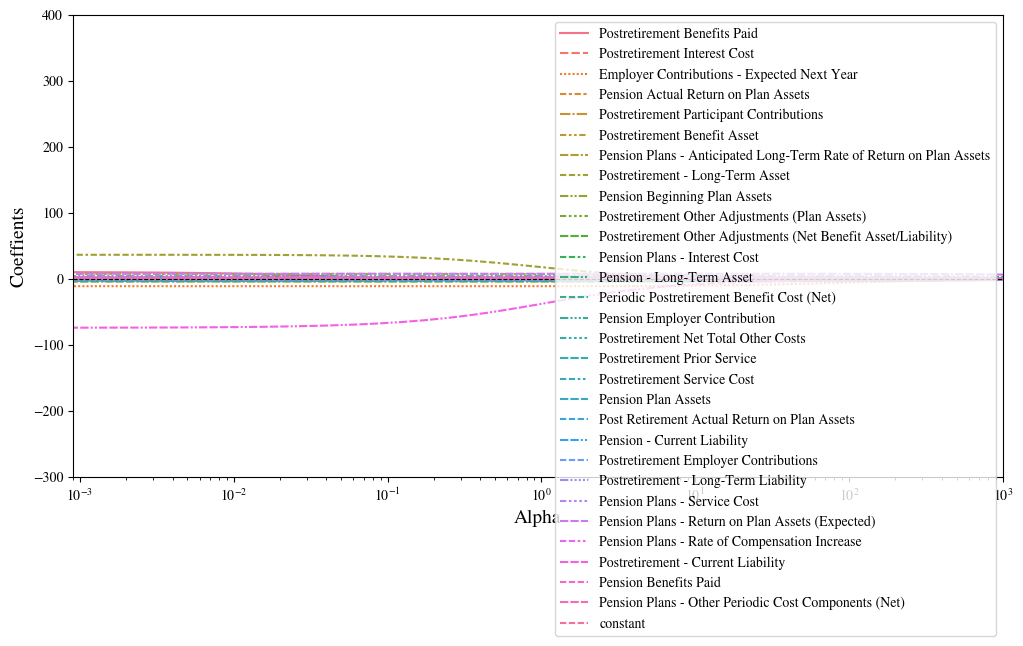

In [31]:
'''
岭回归随着lambda->Inf，压缩惩罚项影响力增加，岭回归系数估计值越接近0.
见下图。
'''
##超参数lambda，有的教材也用alpha

# 设置matplotlib参数，正确显示中文和'-'符号。
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
alpha=10**np.linspace(-5,10,100)
intercept_dict = {}#回归系数保存在这里
for a in alpha:
    result = model.fit_regularized(L1_wt=0,alpha=a,refit=True,profile_scale=True)
    ###保存每次迭代的回归系数估计值
    intercept_dict[a]=result.params
###lambda参数与对应的系数估计值，去掉截距项
params_l2 = pd.DataFrame(intercept_dict).T  #一定要转置
# params_l2=params_l2[[1,2,3,4]]
# params_l2=params_l2[]
###行索引是alpha值，列索引是自变量名
temp_col = exog_vars.copy()
temp_col.append("constant")
params_l2.columns=temp_col
plt.figure(figsize = (12,6))  #设置图像大小，宽12高6

###Seaborn使用行索引为X轴，每一列的数据为Y轴，绘制曲线
#列名作为示意图的标记。
sns.lineplot(data = params_l2,dashes=True)
plt.axhline(y = 0,linestyle = 'dashed',lw = 0.8,color = 'black') #绘制一条平行于x轴的直线方便观察回归系数曲线是否向0逼近
plt.xticks(alpha)  #x轴的刻度值
###对X轴进行对数转换伸缩。
plt.xscale('log')#取x的对数值来变换，若不进行变换曲线就会很丑
plt.ylim(-300,400)  #y轴的最小最大值
plt.xlim(10**(-3)-0.0001,10**3)  #x轴的最小最大值
plt.ylabel('Coeffients',size=14)  #标签
plt.xlabel('Alpha',size=14)
plt.show()

In [32]:
params_l2

,Postretirement Benefits Paid,Postretirement Interest Cost,Employer Contributions - Expected Next Year,Pension Actual Return on Plan Assets,Postretirement Participant Contributions,Postretirement Benefit Asset,Pension Plans - Anticipated Long-Term Rate of Return on Plan Assets,Postretirement - Long-Term Asset,Pension Beginning Plan Assets,Postretirement Other Adjustments (Plan Assets),...,Pension - Current Liability,Postretirement Employer Contributions,Postretirement - Long-Term Liability,Pension Plans - Service Cost,Pension Plans - Return on Plan Assets (Expected),Pension Plans - Rate of Compensation Increase,Postretirement - Current Liability,Pension Benefits Paid,Pension Plans - Other Periodic Cost Components (Net),constant
1.000000e-05,1.077973e+01,-3.036402,-10.724004,0.941044,0.247788,7.878789,-0.860742,36.887527,0.648122,-0.009562,...,1.322896,3.220516,0.608451,-0.950308,8.183815,2.125844,-7.366405e+01,2.621965,0.995160,0.747067
1.417474e-05,1.077856e+01,-3.036402,-10.724004,0.941044,0.247788,7.878788,-0.860742,36.887495,0.648121,-0.009562,...,1.322896,3.220516,0.608451,-0.950308,8.183815,2.125844,-7.366364e+01,2.621965,0.995160,0.747067
2.009233e-05,1.077690e+01,-3.036402,-10.724004,0.941044,0.247788,7.878787,-0.860742,36.887450,0.648121,-0.009562,...,1.322896,3.220516,0.608451,-0.950307,8.183814,2.125844,-7.366305e+01,2.621966,0.995160,0.747067
2.848036e-05,1.077454e+01,-3.036401,-10.724005,0.941045,0.247788,7.878784,-0.860741,36.887385,0.648121,-0.009562,...,1.322896,3.220516,0.608451,-0.950307,8.183814,2.125844,-7.366221e+01,2.621966,0.995160,0.747067
4.037017e-05,1.077119e+01,-3.036400,-10.724005,0.941045,0.247788,7.878781,-0.860741,36.887294,0.648121,-0.009562,...,1.322897,3.220516,0.608451,-0.950307,8.183813,2.125845,-7.366103e+01,2.621967,0.995159,0.747067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.477076e+09,1.007050e-06,0.000093,0.000045,0.000287,0.001170,0.000010,-0.001242,0.000006,0.000055,0.022822,...,0.000023,0.000062,0.000056,0.001158,0.000339,-0.000933,3.242025e-06,0.000075,0.001301,0.000310
3.511192e+09,7.197130e-07,0.000067,0.000032,0.000205,0.000833,0.000007,-0.000887,0.000004,0.000039,0.016313,...,0.000016,0.000044,0.000040,0.000827,0.000242,-0.000667,2.317089e-06,0.000053,0.000930,0.000221
4.977024e+09,5.124540e-07,0.000048,0.000023,0.000146,0.000591,0.000005,-0.000631,0.000003,0.000028,0.011616,...,0.000011,0.000032,0.000028,0.000589,0.000172,-0.000475,1.649875e-06,0.000038,0.000662,0.000157
7.054802e+09,3.639076e-07,0.000034,0.000016,0.000103,0.000419,0.000004,-0.000448,0.000002,0.000020,0.008249,...,0.000008,0.000022,0.000020,0.000418,0.000122,-0.000337,1.171646e-06,0.000027,0.000470,0.000112


In [35]:
# regularized_regression_parameters = model.params
# print(regularized_regression_parameters)

# results_fr = model.fit_regularized(L1_wt=0, alpha=0.04)
# final = sm.regression.linear_model.OLSResults(model, 
#                                               model.normalized_cov_params)
# # model.normalized_cov_params
# print(final.summary())


from sklearn.linear_model import Ridge
skridge = Ridge(alpha=0.2, max_iter=9000, tol=1e-5, fit_intercept=True)
data_y=data["Pension - Projected Benefit Obligation"]
data_x=sm.add_constant(data[exog_vars])
skridge.fit(data_x,data_y)
# result = regression_analysis(data_x, data_y, skridge)

Ridge(alpha=0.2, max_iter=9000, tol=1e-05)